# Analysing precipitation timeseries for S-Band Salesópolis

Analisando série temporal de precipitação com PANDAS

In [337]:
#import ipyparallel as ipp
#rc = ipp.Client()
#with rc[:].sync_imports():
# -*- coding: utf-8 -*-
from __future__ import unicode_literals
import pandas as pd
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as font_manager
import pylab as pl
import seaborn as sns
from scipy import stats
from scipy import optimize
from scipy.spatial.distance import squareform, pdist
from geopy.distance import vincenty
from IPython.display import display, HTML
import sys
#%px 
%pylab inline
sys.version

Populating the interactive namespace from numpy and matplotlib


'2.7.13 |Intel Corporation| (default, Apr 27 2017, 15:33:46) \n[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]'

In [2]:
from os import environ
environ['MPLBACKEND'] = 'module://gr.matplotlib.backend_gr'

In [3]:
font_dirs = ['/home/pedro/fontes', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

mpl.rcParams['font.family'] = 'Arial'

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)
sns.set_context('paper',font_scale=1.4)

## Read 'original' data dataframes

In [4]:
df=pd.read_pickle('dataframe.pickle.gz')

In [5]:
estacoes=pd.read_csv('coordenadas_pluv_saisp.csv',sep=';',index_col=0)

In [6]:
classificacao=pd.read_excel('classificacao_sistemas.xlsx',index_col=0)

In [7]:
upper_left_spol=[-23.29,-46.99]
lower_right_spol=[-24.01,-46.3]
coord_spol=[-23.600779,-45.972671]

In [8]:
def distancia(lat,lon):
    return vincenty([lat,lon],coord_spol).meters/1000.

estacoes['r_spol']=estacoes.apply(lambda x: distancia(x.lat,x.lon),axis=1)

In [9]:
distancias=np.zeros((len(estacoes.index),len(estacoes.index)))
for i in range(len(estacoes.index)):
    for j in range(len(estacoes.index)):
        a=vincenty((estacoes.iloc[i].lat,estacoes.iloc[i].lon),(estacoes.iloc[j].lat,estacoes.iloc[j].lon)).meters/1000
        distancias[i][j]=a
        
qw=pd.DataFrame(distancias)
qw.index=estacoes.index
qw.columns=estacoes.index

In [10]:
est2=estacoes.reset_index()
est2[est2.index==2].estacao_codigo.values

array([5])

for i in range(len(estacoes.index)):
    for j in range(len(estacoes.index)):
        if i!=j and distancias[i][j]<0.5:
            e1=est2[est2.index==i].estacao_codigo.values[0]
            e2=est2[est2.index==j].estacao_codigo.values[0]
            print(e1,e2,distancias[i][j],df.loc[e1].Rg_mm_10.corr(df.loc[e2].Rg_mm_10))

for i in range(len(estacoes.index)):
    for j in range(len(estacoes.index)):
        if i!=j and distancias[i][j]<1.5:
            e1=est2[est2.index==i].estacao_codigo.values[0]
            e2=est2[est2.index==j].estacao_codigo.values[0]
            print(e1,e2,distancias[i][j],df.loc[e1].Rg_mm_10.corr(df.loc[e2].Rg_mm_10))

#dview=rc[:]
#dview.scatter=('k',range(10,110,10))
#%autopx
correla_dista=[]
dista=[]
for k in range(10,110,10):
    for i in range(len(estacoes.index)):
        for j in range(len(estacoes.index)):
            if i!=j and distancias[i][j]<4.5:
                e1=est2[est2.index==i].estacao_codigo.values[0]
                e2=est2[est2.index==j].estacao_codigo.values[0]
                c=df.loc[e1].query('area_chuva>@k-10 & area_chuva<=@k').Rg_mm_10.corr(df.loc[e2].query('area_chuva>@k-10 & area_chuva<=@k').Rg_mm_10)
                #print(e1,e2,distancias[i][j],c)
                correla_dista.append(c)
                dista.append(distancias[i][j])
    correlas=pd.DataFrame(correla_dista,columns=['correlacao'])
    correlas['distancia']=dista
    ax=sns.jointplot(x='distancia',y='correlacao',data=correlas,dropna=True,kind='reg')
    ax.fig.suptitle('Correlacao entre pluviômetros @'+str(k)+'%')
#%autopx

In [11]:
estacoes.describe()

lat         lon      r_spol
count  108.000000  108.000000  108.000000
mean   -23.589564  -46.597590   64.522869
std      0.083630    0.188712   19.052134
min    -23.752079  -47.005560    0.092848
25%    -23.648948  -46.729861   58.324064
50%    -23.602526  -46.597262   64.012825
75%    -23.528890  -46.532296   77.443794
max    -23.391110  -45.971940  107.975049

In [12]:
estacoes.head()

lat        lon     r_spol
estacao_codigo                                 
1              -23.576912 -45.972452   2.643420
2              -23.515830 -46.203060  25.333583
5              -23.530444 -46.595059  64.015498
6              -23.516320 -46.661110  70.906389
9              -23.570000 -46.278610  31.414248

pd.DataFrame(squareform(pdist(estacoes[['lat','lon']].iloc[:, 1:]))*100)

In [13]:
#vincenty([estacoes.lat,estacoes.lon],[])

## Example plots and tests

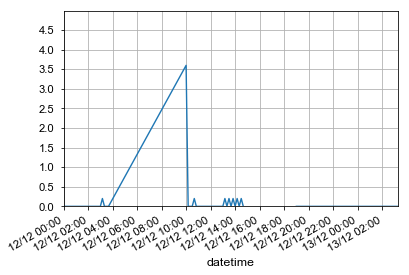

In [14]:
st6=df.loc[6,:]
p=st6.loc['20161212':'20161213'].Rg_mm_10.plot(grid=True,ylim=[0,5],yticks=np.arange(0,5.0,0.5))
p.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m %H:%M"))
p.xaxis.set_major_locator(mdates.HourLocator(interval=2))
#np.arange(0,8,0.5)

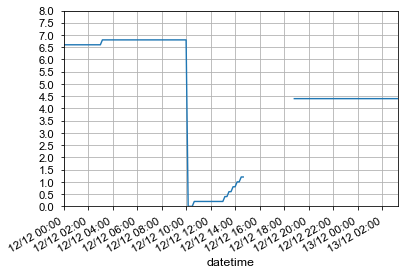

In [15]:
st6=df.loc[6,:]
p=st6.loc['20161212':'20161213'].dado.plot(grid=True,ylim=[0,8],yticks=np.arange(0,8.5,0.5))
p.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m %H:%M"))
p.xaxis.set_major_locator(mdates.HourLocator(interval=2))
#np.arange(0,8,0.5)

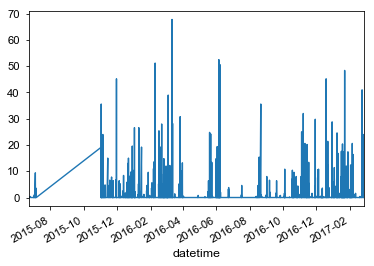

In [16]:
st6[st6.SPOL_merge!='right_only'].Rg_mm_10.plot()

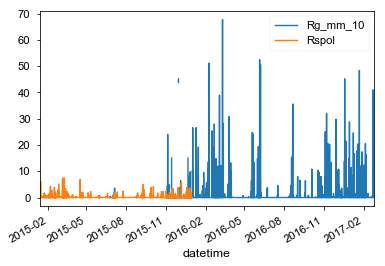

In [17]:
st6[['Rg_mm_10','Rspol']].plot()

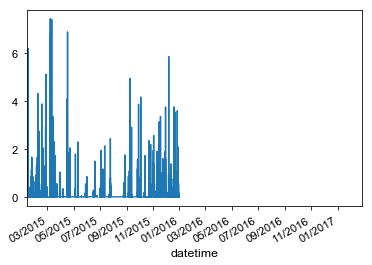

In [18]:
p=st6.Rspol.plot()
p.xaxis.set_major_formatter(mdates.DateFormatter("%m/%Y"))
p.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fde282a5990>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fde2587ea50>], dtype=object)

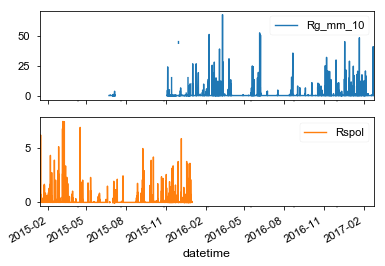

In [19]:
st6[['Rg_mm_10','Rspol']].plot(subplots=True)

In [20]:
st6.head()

dado  Rg_mm_10  Rspol  area_chuva  SPOL_merge  \
datetime                                                             
2015-01-12 17:00:00   NaN       NaN    0.0    5.454687  right_only   
2015-01-12 17:05:00   NaN       NaN    0.0    6.467257  right_only   
2015-01-12 17:10:00   NaN       NaN    0.0    7.817349  right_only   
2015-01-12 17:15:00   NaN       NaN    0.0    9.093731  right_only   
2015-01-12 17:20:00   NaN       NaN    0.0    9.656269  right_only   

                     Rspol_1500  std_1500  Rspol_4500  std_4500  frac_1500  \
datetime                                                                     
2015-01-12 17:00:00         0.0       NaN         0.0       0.0   6.001707   
2015-01-12 17:05:00        -0.0       NaN         0.0       0.0   7.029795   
2015-01-12 17:10:00        -0.0       0.0         0.0       NaN   8.546710   
2015-01-12 17:15:00         0.0       0.0        -0.0       0.0  10.009311   
2015-01-12 17:20:00         0.0       NaN         0.0       NaN  10.525295   

                     frac_4500 SPOLdegr_merge  var_1500  var_4500  
datetime                                                           
2015-01-12 17:00:00   6.700031           both       NaN       0.0  
2015-01-12 17:05:00   7.677685           both       NaN       0.0  
2015-01-12 17:10:00   9.357542           both       0.0       NaN  
2015-01-12 17:15:00  10.847300           both       0.0       0.0  
2015-01-12 17:20:00  11.409839           both       NaN       NaN

In [21]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    
    Reference: https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

In [22]:
l=np.unique(df.index.get_level_values('estacao_codigo'))
l

array([      1,       2,       5,       6,       9,      10,      11,
           137,     143,     149,     157,     168,     173,     174,
           225,     232,     234,     236,     237,     252,     273,
           274,     275,     277,     279,     280,     281,     282,
           283,     284,     286,     294,     296,     306,     344,
           346,     347,     359,     397,     405,     413,     494,
           498,     499,     508,     511,     514,     523,     527,
           528,     563,     580, 1000286, 1000346, 1000350, 1000360,
       1000370, 1000380, 1000390, 1000400, 1000410, 1000420, 1000430,
       1000440, 1000450, 1000470, 1000480, 1000490, 1000500, 1000510,
       1000520, 1000530, 1000540, 1000550, 1000560, 1000570, 1000580,
       1000590, 1000600, 1000610, 1000620, 1000630, 1000640, 1000650,
       1000660, 1000790, 1000791, 1000800, 1000814, 1000817, 1000835,
       1000837, 1000838, 1000839, 1000843, 1000845, 1000846, 1000847,
       1000851, 1000

for d in l:
    k=lag_plot(df.loc[d,:].Rg_mm_10)
    k.figure.suptitle('Lag plot estacao '+str(d))
    k.figure.savefig('lag_1_rg_'+str(d)+'.png')

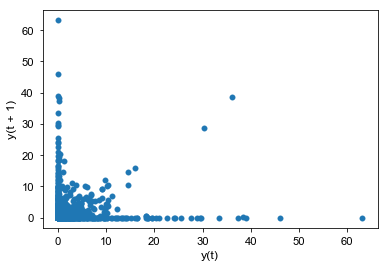

In [23]:
lag_plot(df.loc[5,:].Rg_mm_10,lag=1)

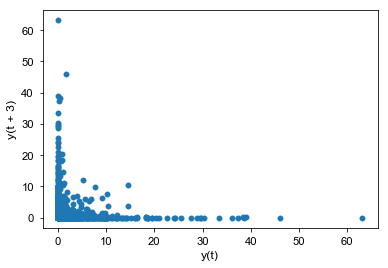

In [24]:
lag_plot(df.loc[5,:].Rg_mm_10,lag=3)

[0 0 0 0 0 0 0 0 0 0]


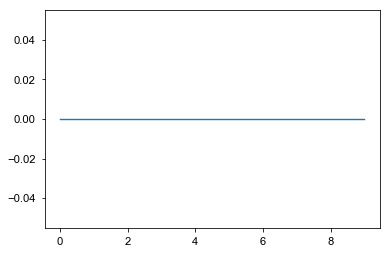

In [25]:
crgr=np.arange(10)
for lg in np.arange(0,10):
    crgr[lg]=crosscorr(df.loc[5,:].Rg_mm_10,df.loc[5,:].Rspol,lag=lg)
print(crgr)
plt.plot(crgr)

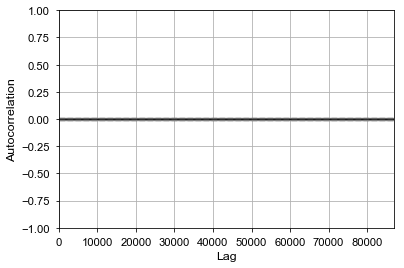

In [26]:
autocorrelation_plot(df.loc[5,:].Rg_mm_10)

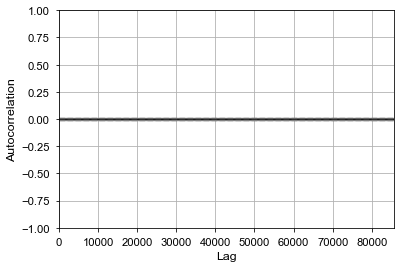

In [27]:
autocorrelation_plot(df.loc[1000410,:].dado)

In [28]:
df=df.assign(logRg=log10(df.Rg_mm_10))

/home/pedro/anaconda2/envs/idp/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


/home/pedro/anaconda2/envs/idp/lib/python2.7/site-packages/numpy/lib/function_base.py:4234: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
/home/pedro/anaconda2/envs/idp/lib/python2.7/site-packages/matplotlib/cbook.py:2032: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
/home/pedro/anaconda2/envs/idp/lib/python2.7/site-packages/matplotlib/cbook.py:2058: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/home/pedro/anaconda2/envs/idp/lib/python2.7/site-packages/matplotlib/cbook.py:2065: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/home/pedro/anaconda2/envs/idp/lib/python2.7/site-packages/matplotlib/cbook.py:2073: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/home/pedro/anaconda2/envs/idp/lib/python2.7/site-packages/matplotlib/cbook.py:2074: Runtim

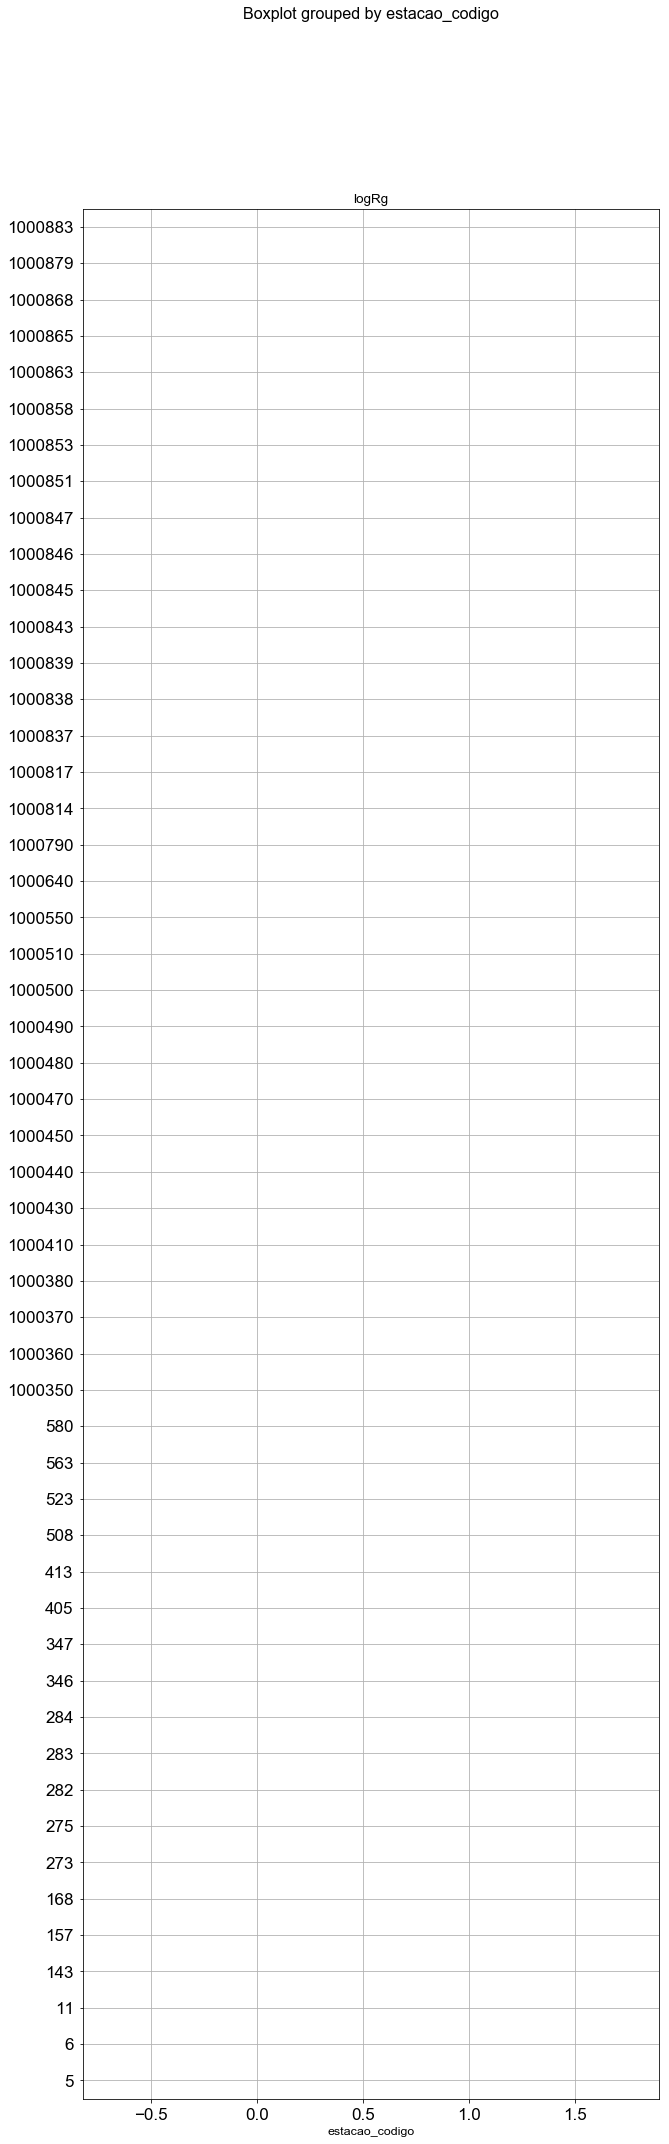

In [29]:
df.dropna().boxplot(by='estacao_codigo',column='logRg',figsize=(10,35),fontsize=17,vert=False,showmeans=True)

df.Rg_mm_10.plot.hist(bins=100)

# Read aggregated data dataframes

In [30]:
station_10m=pd.read_pickle('st10m.pkl.gz')
station_10m=station_10m.join(estacoes.r_spol)
#station_10m=station_10m.join(classificacao.reindex(station_10m.index,level=1))

In [31]:
station_1h=pd.read_pickle('st1h.pkl.gz')
station_1h=station_1h.join(estacoes.r_spol)
#station_1h=station_1h.join(classificacao.reindex(station_1h.index,level=1))

In [32]:
station_1d=pd.read_pickle('st1d.pkl.gz')
station_1d=station_1d.join(estacoes.r_spol)
station_1d_class=station_1d.join(classificacao.reindex(station_1d.index,level=1))

In [33]:
station_10m['std_1500']=np.sqrt(station_10m.var_1500)
station_10m['std_4500']=np.sqrt(station_10m.var_4500)
station_1h['std_1500']=np.sqrt(station_1h.var_1500)
station_1h['std_4500']=np.sqrt(station_1h.var_4500)
station_1d['std_1500']=np.sqrt(station_1d.var_1500)
station_1d['std_4500']=np.sqrt(station_1d.var_4500)

## Correlation of rain gauges with distance

In [301]:
correla_dista=[]
dista=[]
for i in range(len(estacoes.index)):
    for j in range(len(estacoes.index)):
        if i!=j :#and distancias[i][j]<4.5:
            e1=est2[est2.index==i].estacao_codigo.values[0]
            e2=est2[est2.index==j].estacao_codigo.values[0]
            c=station_10m.loc[e1].Rg_mm_10.corr(station_10m.loc[e2].Rg_mm_10)
            #print(e1,e2,distancias[i][j],c)
            correla_dista.append(c)
            dista.append(distancias[i][j])

correlas=pd.DataFrame(correla_dista,columns=['correlacao'])
correlas['distancia']=dista

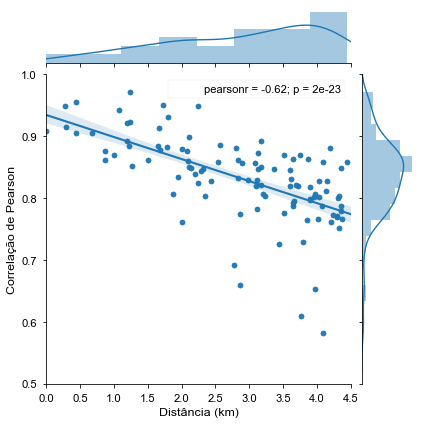

In [361]:
ax=sns.jointplot(x='distancia',y='correlacao',data=correlas.query('distancia<4.5'),kind='reg',xlim=(0,4.5),ylim=(0.5,1),dropna=True)
#ax.fig.suptitle('Correlacao entre pluviômetros')
ax.set_axis_labels("Distância (km)","Correlação de Pearson")
ax.savefig('correlacao_4500m.png')
ax.savefig('correlacao_4500m.pdf',bbox_inches='tight', pad_inches=0)

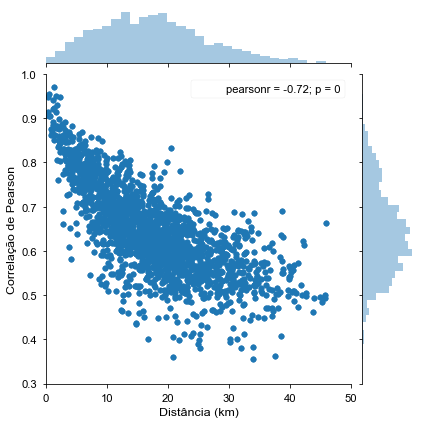

In [362]:
ax=sns.jointplot(x='distancia',y='correlacao',data=correlas,dropna=True,xlim=(0,50),ylim=(0.3,1))

#A,B=fit_exp_nonlinear(correlas.dropna().distancia,correlas.dropna().correlacao)
#ax=sns.regplot(x='Distância (km)',y='Correlação',data=correlas,dropna=True,logx=True,ci=False)
#ax.fig.suptitle('Correlacao entre pluviômetros')
ax.set_axis_labels("Distância (km)","Correlação de Pearson")
ax.savefig('correlacao_50km.png')
ax.savefig('correlacao_50km.pdf',bbox_inches='tight', pad_inches=0)

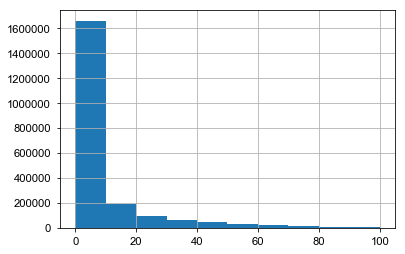

In [37]:
station_10m.area_chuva.hist(bins=range(0,110,10))

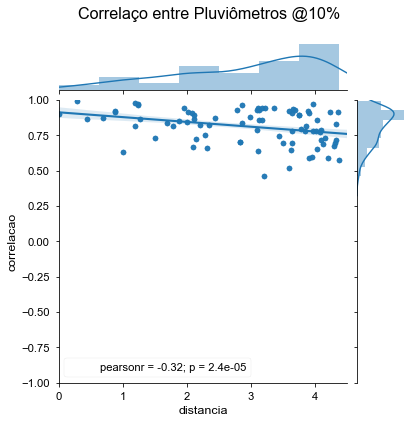

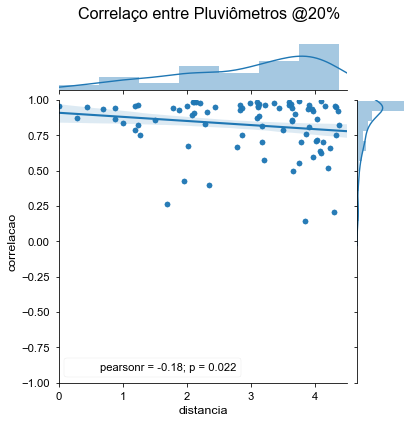

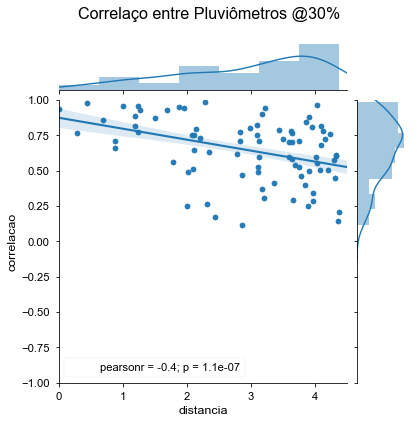

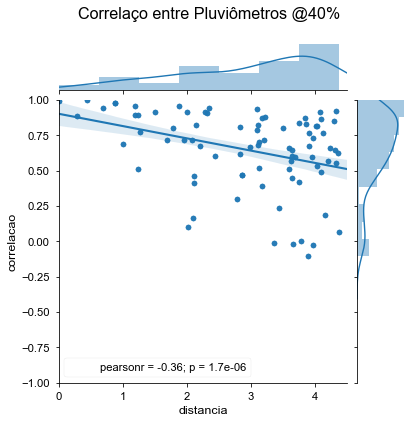

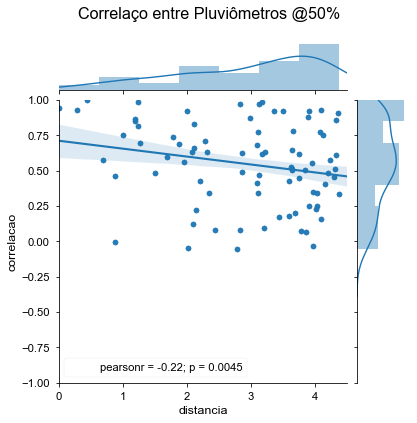

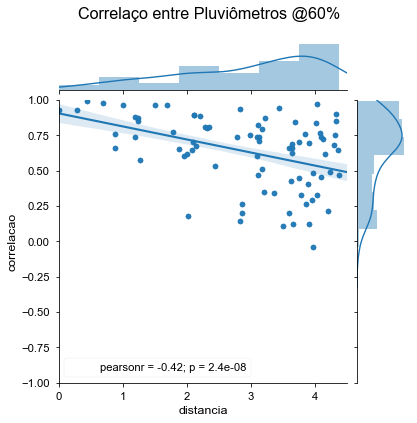

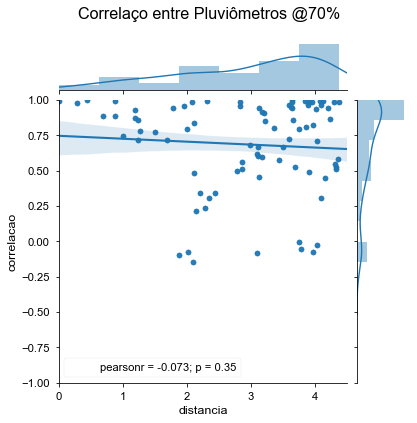

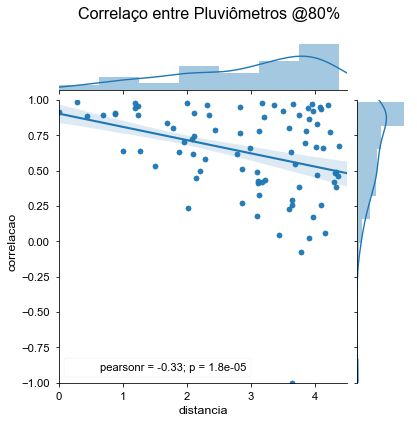

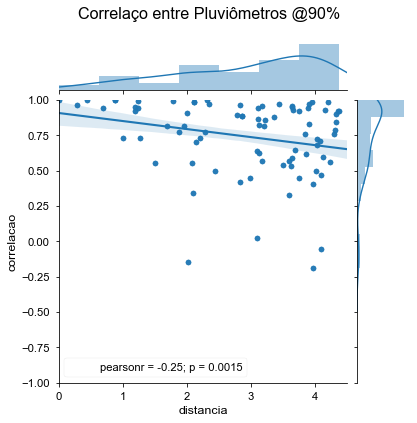

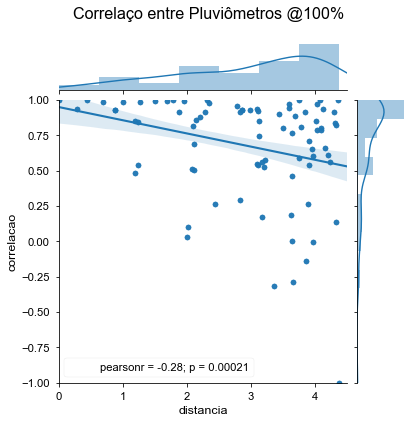

In [38]:
for k in range(10,110,10):
    correla_dista=[]
    dista=[]
    for i in range(len(estacoes.index)):
        for j in range(len(estacoes.index)):
            if i!=j and distancias[i][j]<4.5:
                e1=est2[est2.index==i].estacao_codigo.values[0]
                e2=est2[est2.index==j].estacao_codigo.values[0]
                c=station_10m.loc[e1].query('area_chuva>@k-10 & area_chuva<=@k').Rg_mm_10.corr(station_10m.loc[e2].query('area_chuva>@k-10 & area_chuva<=@k').Rg_mm_10)
                #print(e1,e2,distancias[i][j],c)
                correla_dista.append(c)
                dista.append(distancias[i][j])
    correlas=pd.DataFrame(correla_dista,columns=['correlacao'])
    correlas['distancia']=dista
    ax=sns.jointplot(x='distancia',y='correlacao',data=correlas,dropna=True,kind='reg',ylim=(-1,1),xlim=(0,4.5))
    ax.fig.subplots_adjust(top=0.9)
    ax.fig.suptitle('Correlaço entre Pluviômetros @'+str(k)+'%')
    ax.savefig('correlacao_frac_'+str(k)+'_4500.png')

/home/pedro/anaconda2/envs/idp/lib/python2.7/site-packages/numpy/lib/function_base.py:2995: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/pedro/anaconda2/envs/idp/lib/python2.7/site-packages/numpy/lib/function_base.py:2929: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


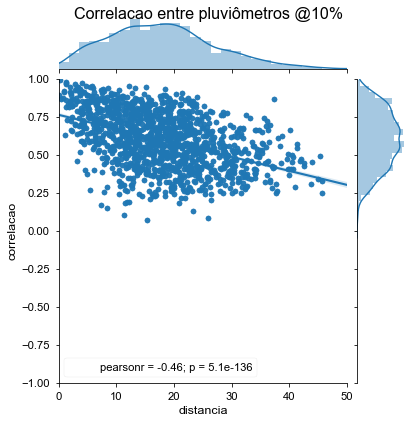

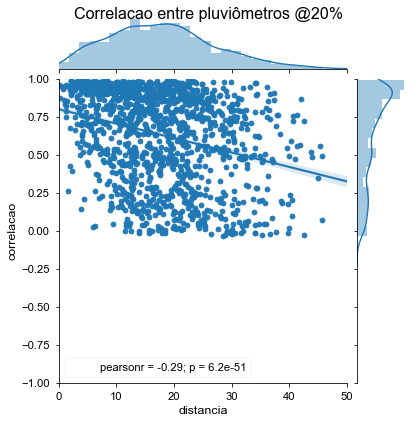

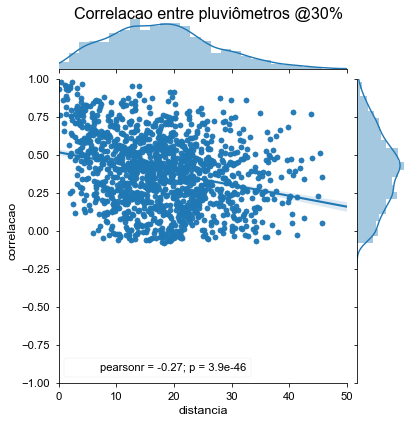

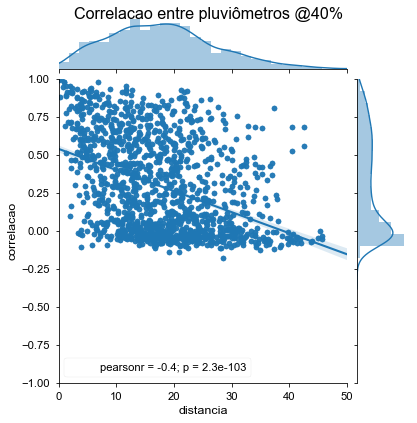

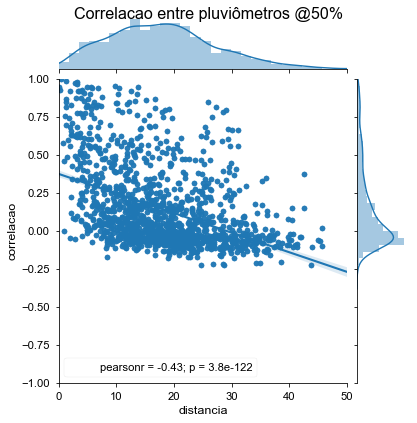

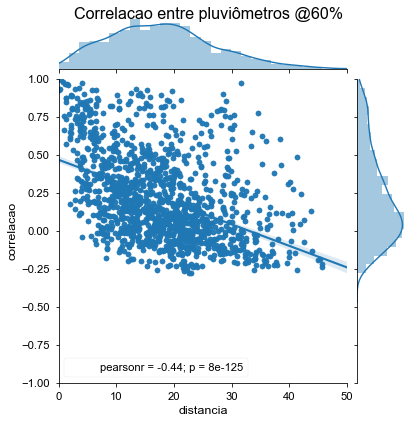

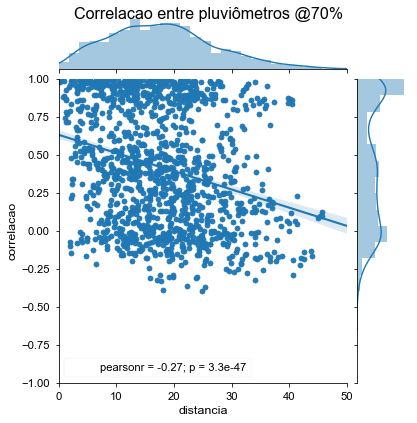

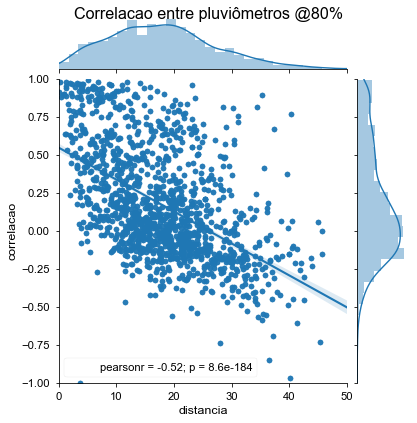

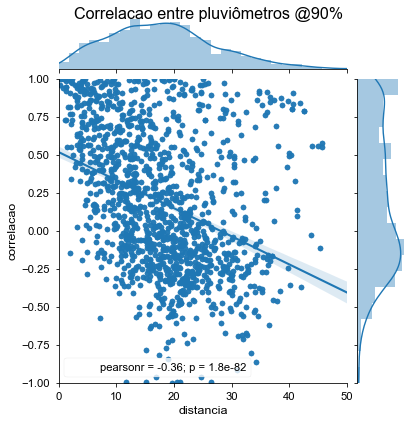

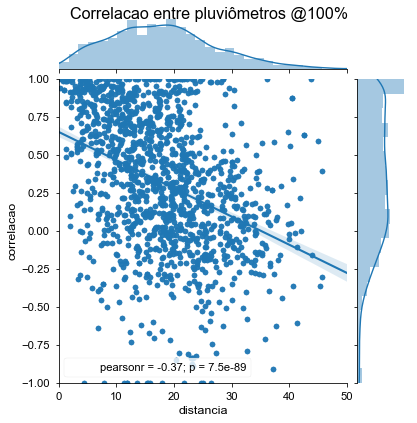

In [39]:
for k in range(10,110,10):
    correla_dista=[]
    dista=[]
    for i in range(len(estacoes.index)):
        for j in range(len(estacoes.index)):
            if i!=j:
                e1=est2[est2.index==i].estacao_codigo.values[0]
                e2=est2[est2.index==j].estacao_codigo.values[0]
                c=station_10m.loc[e1].query('area_chuva>@k-10 & area_chuva<=@k').Rg_mm_10.corr(station_10m.loc[e2].query('area_chuva>@k-10 & area_chuva<=@k').Rg_mm_10)
                #print(e1,e2,distancias[i][j],c)
                correla_dista.append(c)
                dista.append(distancias[i][j])
    correlas=pd.DataFrame(correla_dista,columns=['correlacao'])
    correlas['distancia']=dista
    ax=sns.jointplot(x='distancia',y='correlacao',data=correlas,dropna=True,kind='reg',ylim=(-1,1),xlim=(0,50))
    ax.fig.suptitle('Correlacao entre pluviômetros @'+str(k)+'%')
    ax.savefig('correlacao_frac_'+str(k)+'.png')

## Rainrate Threshold

In [40]:
thr=1 #mm/h

## G/R Ratio

In [41]:
station_1d=station_1d.assign(gr_spol=station_1d.Rg_mm_10/station_1d.Rspol)
station_1d=station_1d.assign(logRg=log10(station_1d.Rg_mm_10))
station_1d=station_1d.assign(logRspol=log10(station_1d.Rspol))
station_1d=station_1d.assign(log_gr_spol=station_1d.logRg-station_1d.logRspol)
station_1d=station_1d.assign(log_2_gr_spol=station_1d.log_gr_spol**2)
station_1d=station_1d.assign(lagneg1_rg=station_1d.Rg_mm_10-station_1d.Rg_mm_10.shift(-1))
station_1d=station_1d.assign(lag1_rg=station_1d.Rg_mm_10.shift(1)-station_1d.Rg_mm_10)

/home/pedro/anaconda2/envs/idp/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/home/pedro/anaconda2/envs/idp/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


In [42]:
station_1h=station_1h.assign(gr_spol=station_1h.Rg_mm_10/station_1h.Rspol)
station_1h=station_1h.assign(logRg=log10(station_1h.Rg_mm_10))
station_1h=station_1h.assign(logRspol=log10(station_1h.Rspol))
station_1h=station_1h.assign(log_gr_spol=station_1h.logRg-station_1h.logRspol)
station_1h=station_1h.assign(log_2_gr_spol=station_1h.log_gr_spol**2)
station_1h=station_1h.assign(lagneg1_rg=station_1h.Rg_mm_10-station_1h.Rg_mm_10.shift(-1))
station_1h=station_1h.assign(lag1_rg=station_1h.Rg_mm_10.shift(1)-station_1h.Rg_mm_10)

/home/pedro/anaconda2/envs/idp/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/home/pedro/anaconda2/envs/idp/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


In [43]:
station_10m=station_10m.assign(gr_spol=station_10m.Rg_mm_10/station_10m.Rspol)
station_10m=station_10m.assign(logRg=log10(station_10m.Rg_mm_10))
station_10m=station_10m.assign(logRspol=log10(station_10m.Rspol))
station_10m=station_10m.assign(log_gr_spol=station_10m.logRg-station_10m.logRspol)
station_10m=station_10m.assign(log_2_gr_spol=station_10m.log_gr_spol**2)
station_10m=station_10m.assign(lagneg1_rg=station_10m.Rg_mm_10-station_10m.Rg_mm_10.shift(-1))
station_10m=station_10m.assign(lag1_rg=station_10m.Rg_mm_10.shift(1)-station_10m.Rg_mm_10)

/home/pedro/anaconda2/envs/idp/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/home/pedro/anaconda2/envs/idp/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


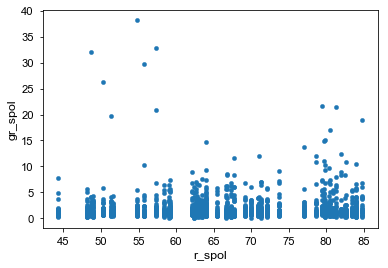

In [44]:
station_1d[(station_1d.Rg_mm_10>thr) & (station_1d.Rspol>thr)].plot.scatter(y='gr_spol',x='r_spol')#,ylim=(0,500))

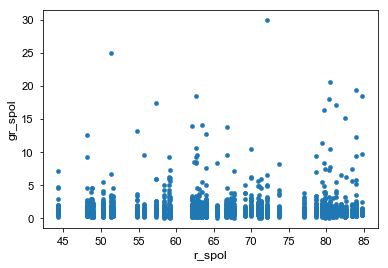

In [45]:
station_1h[(station_1h.Rg_mm_10>thr) & (station_1h.Rspol>thr)].plot.scatter(y='gr_spol',x='r_spol')#,ylim=(0,500))

In [46]:
station_1h[(station_1h.Rg_mm_10>thr) & (station_1h.Rspol>thr) &(station_1h.gr_spol>200)]

Empty DataFrame
Columns: [frac_1500, Rspol_1500, area_chuva, frac_4500, Rg_mm_10, var_4500, var_1500, Rspol_4500, Rspol, r_spol, std_1500, std_4500, gr_spol, logRg, logRspol, log_gr_spol, log_2_gr_spol, lagneg1_rg, lag1_rg]
Index: []

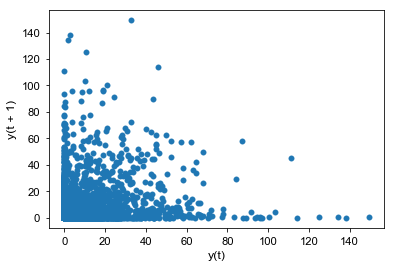

In [47]:
lag_plot(station_1d.Rg_mm_10)

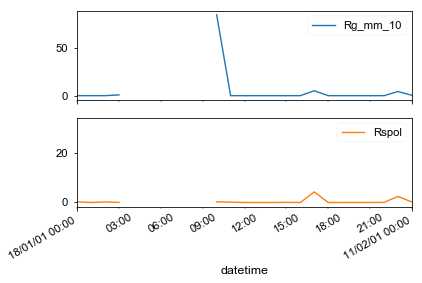

In [48]:
d=station_1h.loc[580,:][['Rg_mm_10','Rspol']].plot(subplots=True,xlim=['2015-11-02','2015-11-03'])
d[0].xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%y %H:%M"))
d[1].xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%y %H:%M"))

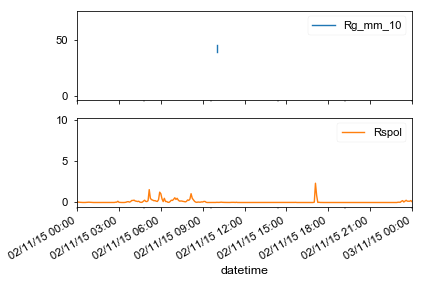

In [49]:
d=df.loc[580,:][['Rg_mm_10','Rspol']].plot(subplots=True,xlim=['2015-11-02','2015-11-03'])
d[0].xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%y %H:%M"))
d[1].xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%y %H:%M"))

In [50]:
station_1d[(station_1d.Rg_mm_10>thr) & (station_1d.Rspol>thr) &(station_1d.gr_spol>200)]

Empty DataFrame
Columns: [frac_1500, Rspol_1500, area_chuva, frac_4500, Rg_mm_10, var_4500, var_1500, Rspol_4500, Rspol, r_spol, std_1500, std_4500, gr_spol, logRg, logRspol, log_gr_spol, log_2_gr_spol, lagneg1_rg, lag1_rg]
Index: []

In [51]:
station_1d.query('Rg_mm_10/Rspol>30 & lag1_rg<-5 & lagneg1_rg>5')

frac_1500  Rspol_1500  area_chuva  frac_4500  \
estacao_codigo datetime                                                   
6              2015-11-21   0.012932    0.000000    0.019075   0.001940   
               2015-11-30   0.482886    1.105015    0.569099   0.429636   
143            2015-07-04   0.871923    4.794279    0.947648   0.784952   
347            2015-11-21   5.640682    2.411192    5.367172   5.879575   
413            2015-11-30   0.020639    0.000000    0.013579   0.021415   
508            2015-11-21   0.011208    0.072888    0.018320   0.001293   
               2015-11-30   0.525168    0.952544    0.609984   0.471012   
563            2015-11-21   6.654985    2.178287    6.350797   6.923250   
580            2015-11-21   0.012932    0.000000    0.019075   0.001940   
1000350        2015-11-15   0.010287    0.000000    0.006819   0.010639   
1000370        2015-11-21   7.653784    1.480085    7.316191   7.953966   
1000410        2015-11-21   7.653784    0.845797    7.316191   7.953966   
1000440        2015-11-21   5.640682    3.555726    5.367172   5.879575   
1000470        2015-11-21   0.011208    0.000000    0.018320   0.001293   
1000480        2015-11-21   0.012932    0.012224    0.019075   0.001940   
1000550        2015-11-21   7.653784    1.323210    7.316191   7.953966   
1000790        2015-11-21   5.640682    4.588724    5.367172   5.879575   
1000839        2015-11-30   0.402675    0.081130    0.481756   0.355670   
1000851        2015-07-04   0.871923    4.794042    0.947648   0.784952   
               2015-11-21   5.640682    0.718401    5.367172   5.879575   
               2015-11-30   0.384466    0.407520    0.460140   0.339851   
1000879        2015-11-30   0.020639    0.000000    0.013579   0.021415   

                           Rg_mm_10  var_4500  var_1500  Rspol_4500     Rspol  \
estacao_codigo datetime                                                         
6              2015-11-21       7.8  0.000000  0.000000    0.000000  0.000000   
               2015-11-30      89.4  0.325456  0.193372    1.287723  0.065906   
143            2015-07-04      16.4  0.883865  0.612281    4.953609  0.339351   
347            2015-11-21      22.8  1.081555  0.597345    2.457017  0.181138   
413            2015-11-30      34.4  0.001943  0.000177    0.001700  0.000000   
508            2015-11-21      17.8  0.002418  0.001260    0.045208  0.004180   
               2015-11-30      24.0  0.064958  0.049540    0.986617  0.061379   
563            2015-11-21      16.8  0.381471  0.356103    2.042675  0.224357   
580            2015-11-21      16.6  0.000312  0.000000    0.000000  0.000000   
1000350        2015-11-15      25.2  0.000281  0.000496    0.004898  0.000000   
1000370        2015-11-21      21.0  0.174157  0.166000    1.446146  0.102033   
1000410        2015-11-21      16.0  0.143591  0.079222    0.932662  0.054455   
1000440        2015-11-21      22.6  1.610585  0.839396    4.063083  0.186178   
1000470        2015-11-21      35.4  0.000536  0.000242    0.000000  0.000000   
1000480        2015-11-21      25.6  0.008267  0.001279    0.008801  0.000000   
1000550        2015-11-21      19.4  0.149631  0.138917    1.283199  0.148684   
1000790        2015-11-21      16.8  1.366973  0.855835    4.397082  0.414575   
1000839        2015-11-30      51.6  0.143579  0.011400    0.114731  0.006100   
1000851        2015-07-04      19.6  1.409011  0.750684    5.129954  0.399822   
               2015-11-21      19.6  0.186627  0.121212    0.837485  0.043369   
               2015-11-30     114.2  0.441340  0.794181    0.398412  0.031554   
1000879        2015-11-30      26.6  0.008479  0.001944    0.000000  0.000000   

                              r_spol  std_1500  std_4500      gr_spol  \
estacao_codigo datetime                                                 
6              2015-11-21  70.906389  0.000000  0.000000          inf   
               2015-11-30  70.906389  0.439741  0.570488  1356

In [52]:
station_1h.query('Rg_mm_10/Rspol>15 & lag1_rg<-2 & lagneg1_rg>2')

frac_1500  Rspol_1500  area_chuva  \
estacao_codigo datetime                                                 
6              2015-12-26 21:00:00  28.846602    4.117270   27.679819   
157            2015-11-09 17:00:00   8.097972   12.219270    7.796012   
               2015-11-28 23:00:00  41.845989    2.606195   39.758345   
               2015-12-07 02:00:00   9.165826    1.044137    9.087911   
               2015-12-19 22:00:00  77.899338    4.881448   76.571552   
               2015-12-25 19:00:00  19.288615    7.986352   17.977964   
               2015-12-27 22:00:00   1.057832    0.008461    0.987999   
168            2015-06-24 10:00:00   0.025864    0.000000    0.020044   
275            2015-06-24 10:00:00   0.019182    0.000000    0.016811   
282            2015-06-24 10:00:00   0.025864    0.000000    0.020044   
283            2015-06-24 10:00:00   0.025864    0.000000    0.020044   
284            2015-06-24 10:00:00   0.025864    0.009629    0.020044   
347            2015-06-24 10:00:00   0.025864    0.002919    0.020044   
405            2015-06-24 10:00:00   0.025864    0.000000    0.020044   
413            2015-06-24 10:00:00   0.025864    0.000000    0.020044   
               2015-12-25 19:00:00  19.288615    1.387845   17.977964   
508            2015-06-24 10:00:00   0.025864    0.000000    0.020044   
563            2015-06-24 10:00:00   0.025864    0.000000    0.020044   
580            2015-06-24 10:00:00   0.019182    0.000000    0.016811   
               2015-11-29 17:00:00  19.077178    3.025016   18.103727   
1000350        2015-06-24 10:00:00   0.025864    0.000000    0.020044   
1000360        2015-06-24 10:00:00   0.025864    0.000000    0.020044   
1000370        2015-06-24 10:00:00   0.025864    0.000000    0.020044   
               2015-11-09 16:00:00   9.619026    0.324016    9.073169   
1000380        2015-06-24 10:00:00   0.019182    0.000000    0.016811   
1000410        2015-06-24 10:00:00   0.025864    0.000000    0.020044   
1000430        2015-06-24 10:00:00   0.025864    0.000000    0.020044   
1000440        2015-06-24 10:00:00   0.025864    0.000000    0.020044   
1000450        2015-06-24 10:00:00   0.025864    0.000000    0.020044   
1000470        2015-12-22 20:00:00  21.455359   18.311425   20.113672   
1000490        2015-06-24 10:00:00   0.025864    0.000000    0.020044   
1000500        2015-06-24 10:00:00   0.025864    0.000000    0.020044   
1000510        2015-06-24 10:00:00   0.025864    0.000000    0.020044   
1000550        2015-06-24 10:00:00   0.025864    0.000000    0.020044   
1000640        2015-12-22 20:00:00  21.372918   12.257485   20.056771   
1000814        2015-06-24 10:00:00   0.025864    0.000000    0.020044   
               2015-12-16 16:00:00   2.597377    2.335534    2.707622   
1000817        2015-06-24 10:00:00   0.025864    0.040592    0.020044   
1000837        2015-06-24 10:00:00   0.025864    0.000000    0.020044   
1000845        2015-06-24 10:00:00   0.025864    0.000000    0.020044   
1000847        2015-06-24 10:00:00   0.025864    0.051122    0.020044   
1000851        2015-06-24 10:00:00   0.025864    0.000000    0.020044   
               2015-12-25 22:00:00  11.194199    0.081604   10.595774   
1000853        2015-06-24 10:00:00   0.025864    0.000000    0.020044   
1000858        2015-06-24 10:00:00   0.019182    0.000000    0.016811   
1000868        2015-06-24 10:00:00   0.025864    0.000000    0.020044   
1000879        2015-06-24 10:00:00   0.025864    0.000000    0.020044   

                                    frac_4500  Rg_mm_10     var_4500  \
estacao_codigo datetime                                                
6              2015-12-26 21:00:00  29.810353      9.80   667.241572   
157            2015-11-09 17:00:00   8.414373     17.20    36.223692   
               2015-11-28 23:00:00  43.729094     19.60   121.402281   
               2015-12-07 02:00:00   9.077566     28.00     0.661827   
               2015-12-19 

In [53]:
station_10m.query('Rg_mm_10>@thr & (lag1_rg<-30 | lag1_rg!=lag1_rg) & (lagneg1_rg>30 | lagneg1_rg!=lagneg1_rg)')

frac_1500  Rspol_1500  area_chuva  \
estacao_codigo datetime                                                 
5              2015-11-02 10:00:00  11.396906    0.332477   11.208100   
               2015-12-07 10:00:00   0.065952    0.028155    0.236655   
               2016-01-02 10:00:00        NaN         NaN         NaN   
               2016-01-15 10:00:00        NaN         NaN         NaN   
               2016-03-11 10:00:00        NaN         NaN         NaN   
               2016-06-07 10:00:00        NaN         NaN         NaN   
               2016-08-21 10:00:00        NaN         NaN         NaN   
               2016-11-29 10:00:00        NaN         NaN         NaN   
               2017-01-16 10:00:00        NaN         NaN         NaN   
               2017-02-25 10:00:00        NaN         NaN         NaN   
6              2015-11-02 10:00:00  11.204220    0.000000   11.016061   
               2015-11-30 10:00:00   0.043969    0.000000    0.025864   
               2016-01-15 10:00:00        NaN         NaN         NaN   
               2016-02-09 10:00:00        NaN         NaN         NaN   
               2016-03-04 10:00:00        NaN         NaN         NaN   
               2016-03-11 10:00:00        NaN         NaN         NaN   
               2016-03-26 10:00:00        NaN         NaN         NaN   
               2016-06-05 10:00:00        NaN         NaN         NaN   
               2016-06-07 10:00:00        NaN         NaN         NaN   
               2016-08-21 10:00:00        NaN         NaN         NaN   
               2016-11-07 10:00:00        NaN         NaN         NaN   
               2016-12-19 10:00:00        NaN         NaN         NaN   
               2017-01-22 10:00:00        NaN         NaN         NaN   
               2017-02-23 10:00:00        NaN         NaN         NaN   
11             2015-11-02 10:00:00  11.396906    0.000000   11.208100   
               2015-11-10 10:00:00        NaN         NaN         NaN   
               2015-12-13 10:00:00   0.077591    0.000000    0.102808   
               2016-01-10 10:00:00        NaN         NaN         NaN   
               2016-01-26 10:00:00        NaN         NaN         NaN   
               2016-02-16 10:00:00        NaN         NaN         NaN   
...                                       ...         ...         ...   
1000868        2017-02-23 10:00:00        NaN         NaN         NaN   
1000879        2015-11-02 10:00:00  11.204220    0.425968   11.016061   
               2015-12-27 10:00:00        NaN         NaN         NaN   
               2016-01-02 10:00:00        NaN         NaN         NaN   
               2016-01-10 10:00:00        NaN         NaN         NaN   
               2016-01-15 10:00:00        NaN         NaN         NaN   
               2016-02-16 10:00:00        NaN         NaN         NaN   
               2016-03-11 10:00:00        NaN         NaN         NaN   
               2016-05-21 10:00:00        NaN         NaN         NaN   
               2016-06-07 10:00:00        NaN         NaN         NaN   
               2016-08-21 10:00:00        NaN         NaN         NaN   
               2016-10-21 10:00:00        NaN         NaN         NaN   
               2016-12-22 10:00:00        NaN         NaN         NaN   
               2017-01-10 10:00:00        NaN         NaN         NaN   
               2017-01-17 10:00:00        NaN         NaN         NaN   
               2017-01-22 10:00:00        NaN         NaN         NaN   
               2017-02-07 10:00:00        NaN         NaN         NaN   
               2017-02-25 10:00:00        NaN         NaN         NaN   
1000883        2015-11-09 10:00:00   0.000000    0.000000    0.000000   
               2015-12-23 10:00:00        NaN         NaN         NaN   
               2016-01-02 10:00:00        NaN         NaN         NaN   
               2016-01-10 10:00:00        NaN         NaN         NaN   
               2016-0

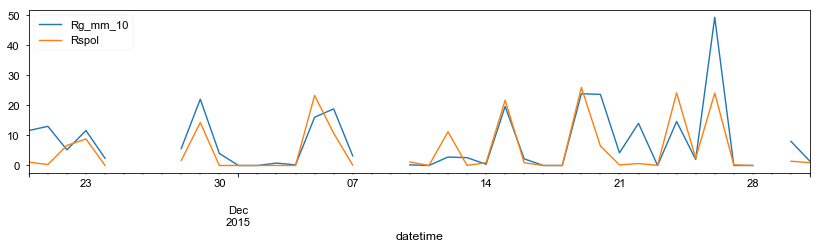

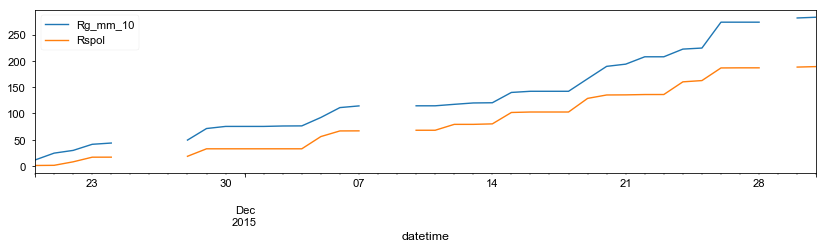

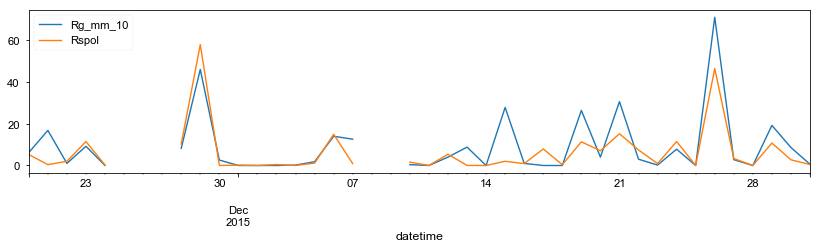

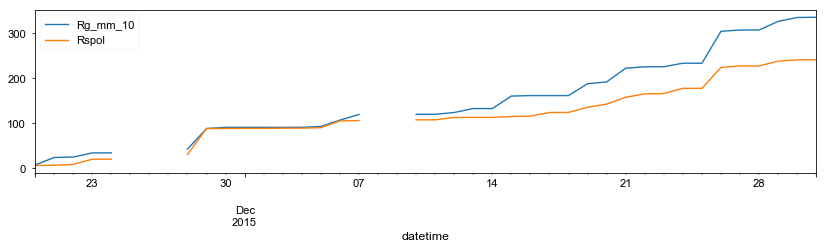

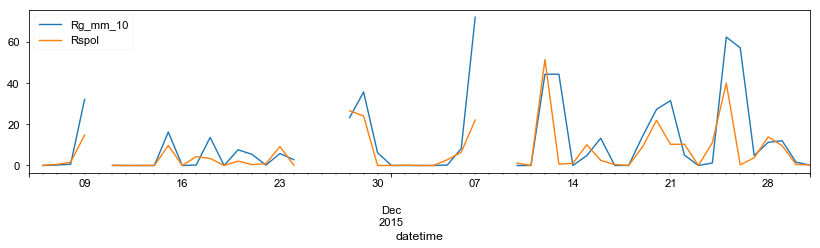

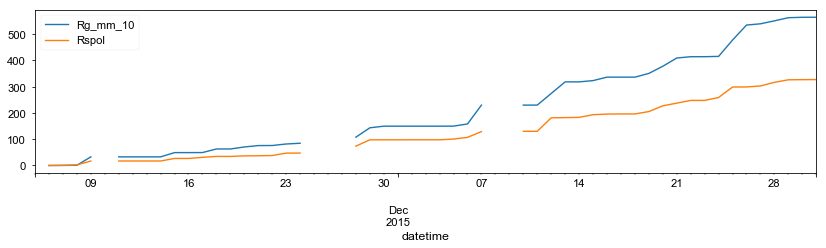

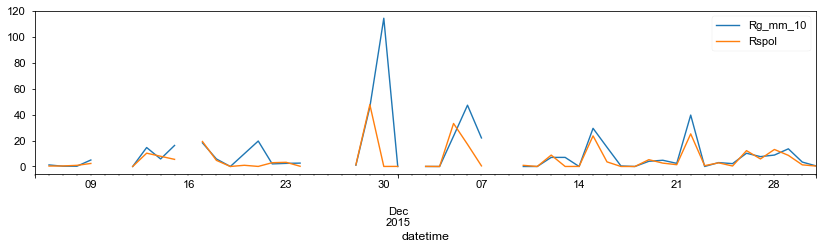

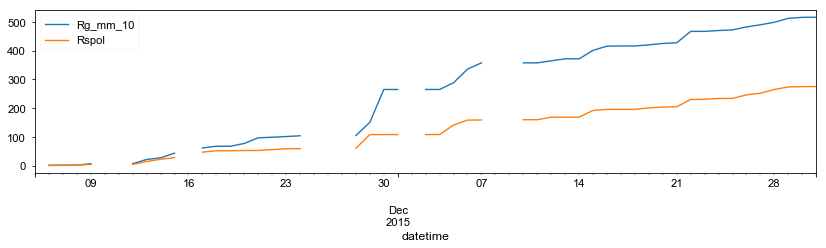

In [54]:
st=station_1d.loc[1000640,:]
st.loc['2015-11-20':'2015-12-31'][['Rg_mm_10','Rspol']].plot(figsize=(14,3))
st.loc['2015-11-20':'2015-12-31'][['Rg_mm_10','Rspol']].cumsum().plot(figsize=(14,3))
st=station_1d.loc[1000790,:]
st.loc['2015-11-20':'2015-12-31'][['Rg_mm_10','Rspol']].plot(figsize=(14,3))
st.loc['2015-11-20':'2015-12-31'][['Rg_mm_10','Rspol']].cumsum().plot(figsize=(14,3))
st=station_1d.loc[157,:]
st.loc['2015-11-05':'2015-12-31'][['Rg_mm_10','Rspol']].plot(figsize=(14,3))
st.loc['2015-11-05':'2015-12-31'][['Rg_mm_10','Rspol']].cumsum().plot(figsize=(14,3))
st=station_1d.loc[1000851,:]
st.loc['2015-11-05':'2015-12-31'][['Rg_mm_10','Rspol']].plot(figsize=(14,3))
st.loc['2015-11-05':'2015-12-31'][['Rg_mm_10','Rspol']].cumsum().plot(figsize=(14,3))

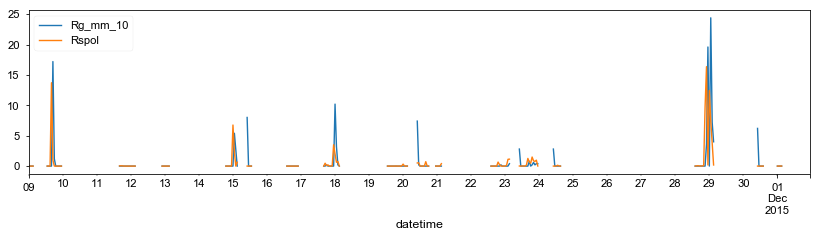

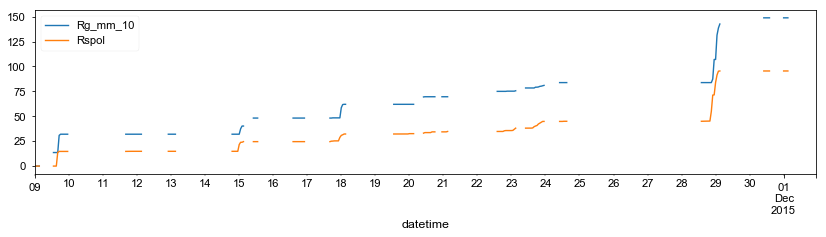

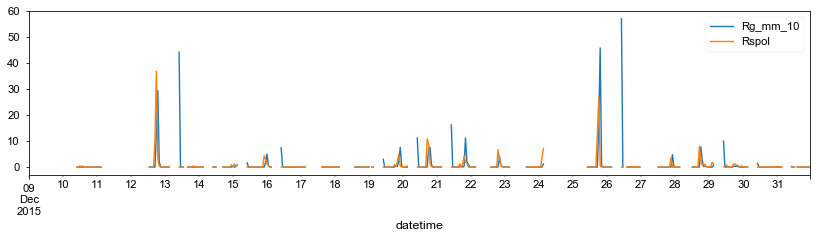

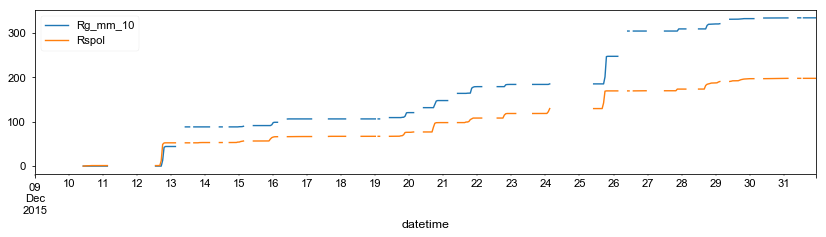

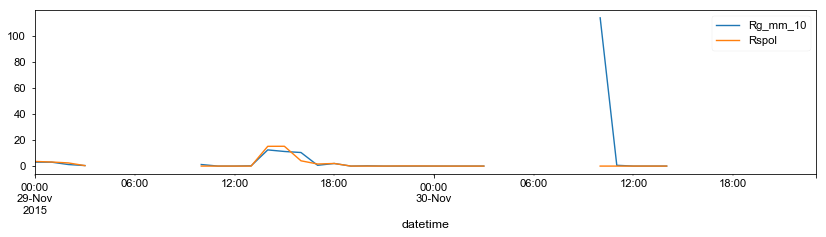

In [55]:
st=station_1h.loc[157,:]
st.loc['2015-11-09':'2015-12-01'][['Rg_mm_10','Rspol']].plot(figsize=(14,3))
st.loc['2015-11-09':'2015-12-01'][['Rg_mm_10','Rspol']].cumsum().plot(figsize=(14,3))
st.loc['2015-12-09':'2015-12-31'][['Rg_mm_10','Rspol']].plot(figsize=(14,3))
st.loc['2015-12-09':'2015-12-31'][['Rg_mm_10','Rspol']].cumsum().plot(figsize=(14,3))
st=station_1h.loc[1000851,:]
st.loc['2015-11-29':'2015-11-30'][['Rg_mm_10','Rspol']].plot(figsize=(14,3))

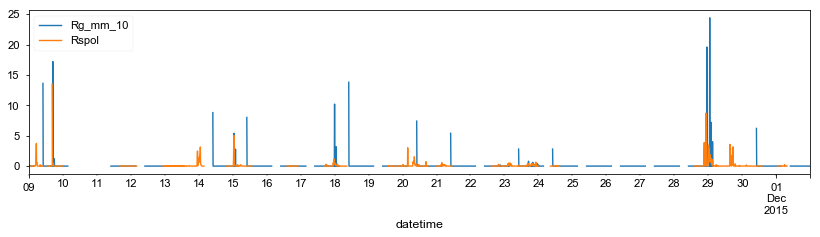

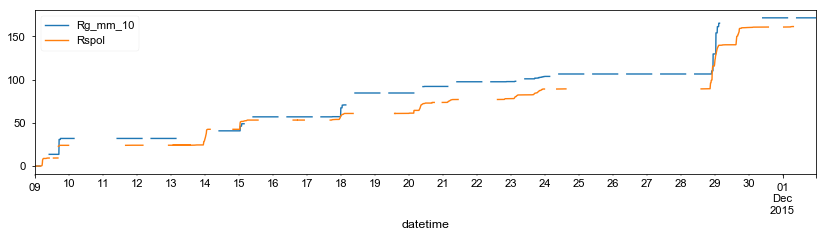

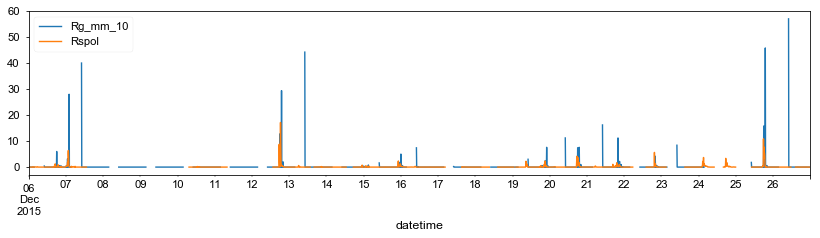

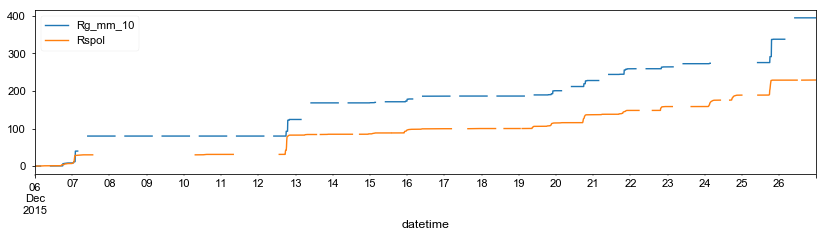

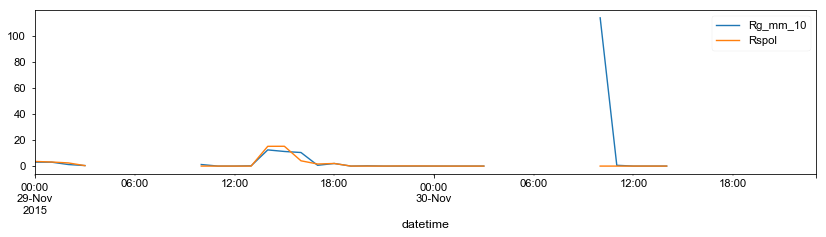

In [56]:
st=station_10m.loc[157,:]
st.loc['2015-11-09':'2015-12-01'][['Rg_mm_10','Rspol']].plot(figsize=(14,3))
st.loc['2015-11-09':'2015-12-01'][['Rg_mm_10','Rspol']].cumsum().plot(figsize=(14,3))
st.loc['2015-12-06':'2015-12-26'][['Rg_mm_10','Rspol']].plot(figsize=(14,3))
st.loc['2015-12-06':'2015-12-26'][['Rg_mm_10','Rspol']].cumsum().plot(figsize=(14,3))
st=station_1h.loc[1000851,:]
st.loc['2015-11-29':'2015-11-30'][['Rg_mm_10','Rspol']].plot(figsize=(14,3))

In [57]:
st.loc['2015-11-29':'2015-11-30']

frac_1500  Rspol_1500  area_chuva  frac_4500  Rg_mm_10  \
datetime                                                                      
2015-11-29 00:00:00  77.792327   41.658542   75.763630  78.669758       3.0   
2015-11-29 01:00:00  95.918360   40.304273   94.012194  96.430464       3.0   
2015-11-29 02:00:00  67.848968   28.111459   65.244801  68.733188       1.2   
2015-11-29 03:00:00  36.178035    5.022177   33.998681  36.831743       0.4   
2015-11-29 04:00:00        NaN         NaN         NaN        NaN       NaN   
2015-11-29 05:00:00        NaN         NaN         NaN        NaN       NaN   
2015-11-29 06:00:00        NaN         NaN         NaN        NaN       NaN   
2015-11-29 07:00:00        NaN         NaN         NaN        NaN       NaN   
2015-11-29 08:00:00        NaN         NaN         NaN        NaN       NaN   
2015-11-29 09:00:00        NaN         NaN         NaN        NaN       NaN   
2015-11-29 10:00:00   0.022631    0.000000    0.019398   0.031683       1.2   
2015-11-29 11:00:00   0.097636    0.000000    0.097313   0.101516       0.0   
2015-11-29 12:00:00   1.153528    0.000000    1.128634   1.203639       0.0   
2015-11-29 13:00:00   6.791848    0.000000    6.239978   7.482736       0.2   
2015-11-29 14:00:00  16.249612  182.579558   15.152015  17.563819      12.4   
2015-11-29 15:00:00  26.999923  171.781439   25.261225  28.939065      11.2   
2015-11-29 16:00:00  27.144114   47.679738   25.467812  28.739590      10.4   
2015-11-29 17:00:00  19.077178   17.786297   18.103727  19.790697       0.6   
2015-11-29 18:00:00   8.401226   26.013603    8.101852   8.606197       2.0   
2015-11-29 19:00:00   7.821552    0.785851    7.484352   8.029110       0.0   
2015-11-29 20:00:00   8.942104    0.090308    8.708036   9.088881       0.2   
2015-11-29 21:00:00   6.716196    0.004682    6.510901   6.786675       0.0   
2015-11-29 22:00:00   3.951673    1.253690    3.884751   3.961049       0.0   
2015-11-29 23:00:00   0.432896    1.320960    0.665024   0.271894       0.0   
2015-11-30 00:00:00   0.239564    0.358326    0.400243   0.149687       0.0   
2015-11-30 01:00:00   1.489111    0.000000    1.548921   1.410550       0.0   
2015-11-30 02:00:00   0.624289    0.005834    0.904588   0.492383       0.0   
2015-11-30 03:00:00   1.330695    0.000000    1.624574   1.213338       0.0   
2015-11-30 04:00:00        NaN         NaN         NaN        NaN       NaN   
2015-11-30 05:00:00        NaN         NaN         NaN        NaN       NaN   
2015-11-30 06:00:00        NaN         NaN         NaN        NaN       NaN   
2015-11-30 07:00:00        NaN         NaN         NaN        NaN       NaN   
2015-11-30 08:00:00        NaN         NaN         NaN        NaN       NaN   
2015-11-30 09:00:00        NaN         NaN         NaN        NaN       NaN   
2015-11-30 10:00:00   0.024571    0.000000    0.012124   0.027157     113.6   
2015-11-30 11:00:00   0.013579    0.000000    0.006789   0.019236       0.6   
2015-11-30 12:00:00   0.022146    0.043360    0.016812   0.029097       0.0   
2015-11-30 13:00:00   0.018913    0.000000    0.014225   0.016327       0.0   
2015-11-30 14:00:00   0.046555    0.000000    0.034916   0.000000       0.0   
2015-11-30 15:00:00        NaN         NaN         NaN        NaN       NaN   
2015-11-30 16:00:00        NaN         NaN         NaN        NaN       NaN   
2015-11-30 17:00:00        NaN         NaN         NaN        NaN       NaN   
2015-11-30 18:00:00        NaN         NaN         NaN        NaN       NaN   
2015-11-30 19:00:00        NaN         NaN         NaN        NaN       NaN   
2015-11-30 20:00:00        NaN         NaN         NaN        NaN       NaN   
2015-11-30 21:00:00        NaN         NaN         NaN        NaN       NaN   
2015-11-30 22:00:00        NaN         NaN         NaN        NaN       NaN   
2015-11-30 23:00:00        NaN         NaN         NaN        NaN       NaN   

                        var_4500     var_1500  Rspol_4500      Rspol  

In [58]:
with pd.option_context('mode.use_inf_as_null', True):
    var_log_gr_1d=station_1d.dropna().query('Rg_mm_10>@thr').log_2_gr_spol.groupby(level=0).sum()/station_1d.dropna().query('Rg_mm_10>@thr').log_2_gr_spol.groupby(level=0).count()
var_log_gr_1d=var_log_gr_1d.to_frame()
var_log_gr_1d=var_log_gr_1d.join(estacoes.r_spol)

In [59]:
with pd.option_context('mode.use_inf_as_null', True):
    var_log_gr_1h=station_1h.dropna().query('Rg_mm_10>@thr').log_2_gr_spol.groupby(level=0).sum()/station_1h.dropna().query('Rg_mm_10>@thr').log_2_gr_spol.groupby(level=0).count()
var_log_gr_1h=var_log_gr_1h.to_frame()
var_log_gr_1h=var_log_gr_1h.join(estacoes.r_spol)

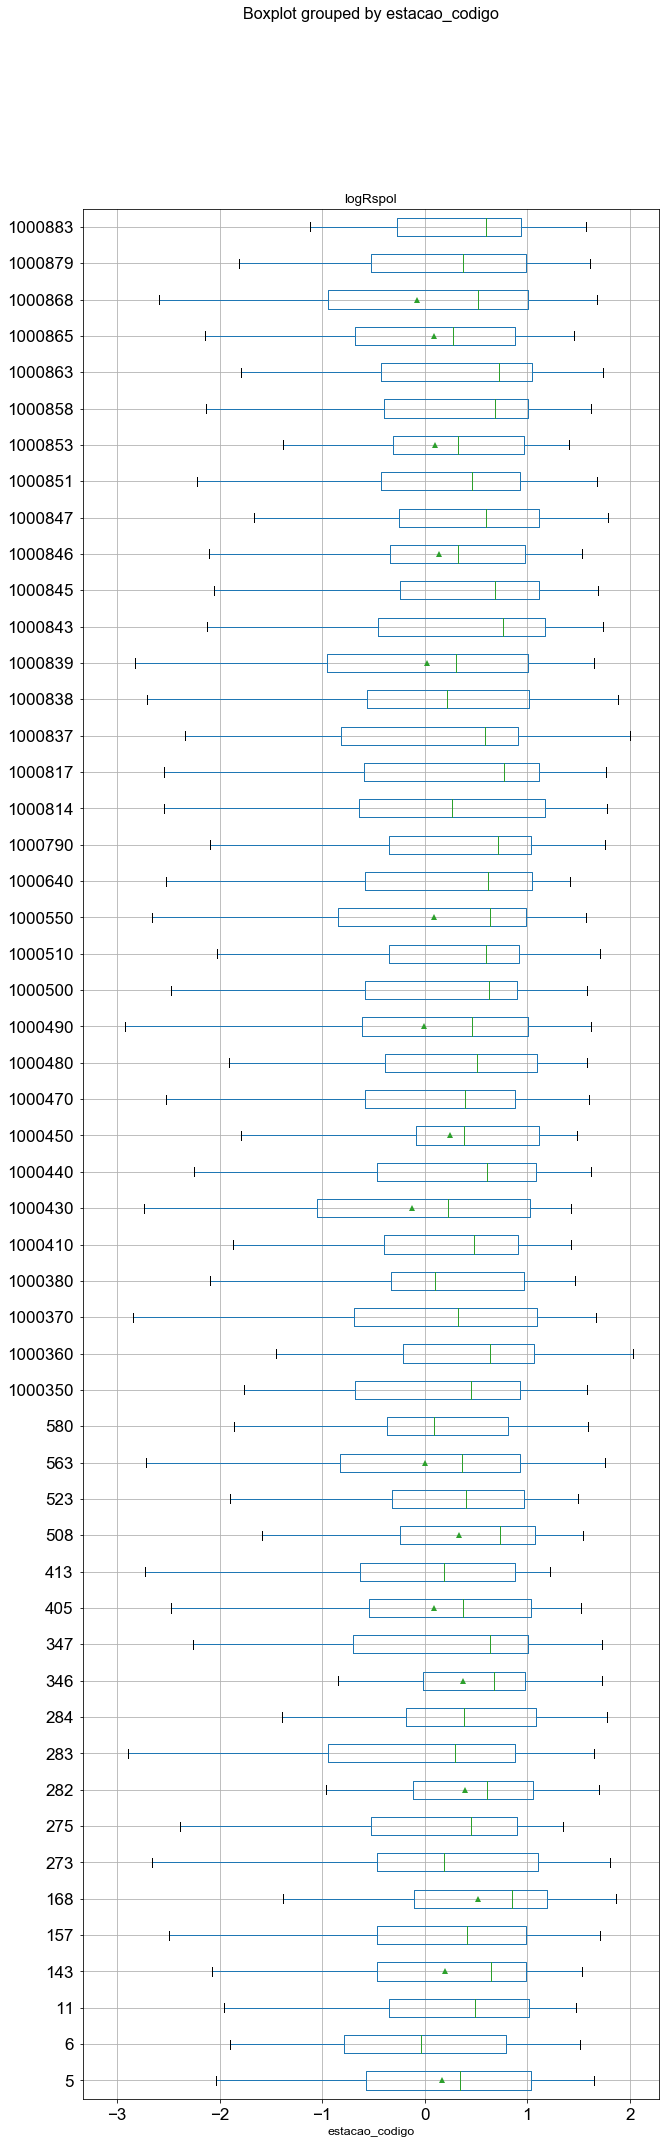

In [60]:
(station_1d.dropna().boxplot(by='estacao_codigo',column='logRspol',figsize=(10,35),fontsize=17,vert=False,showmeans=True)).figure.savefig('boxplot_log(Rradar_spol).png')

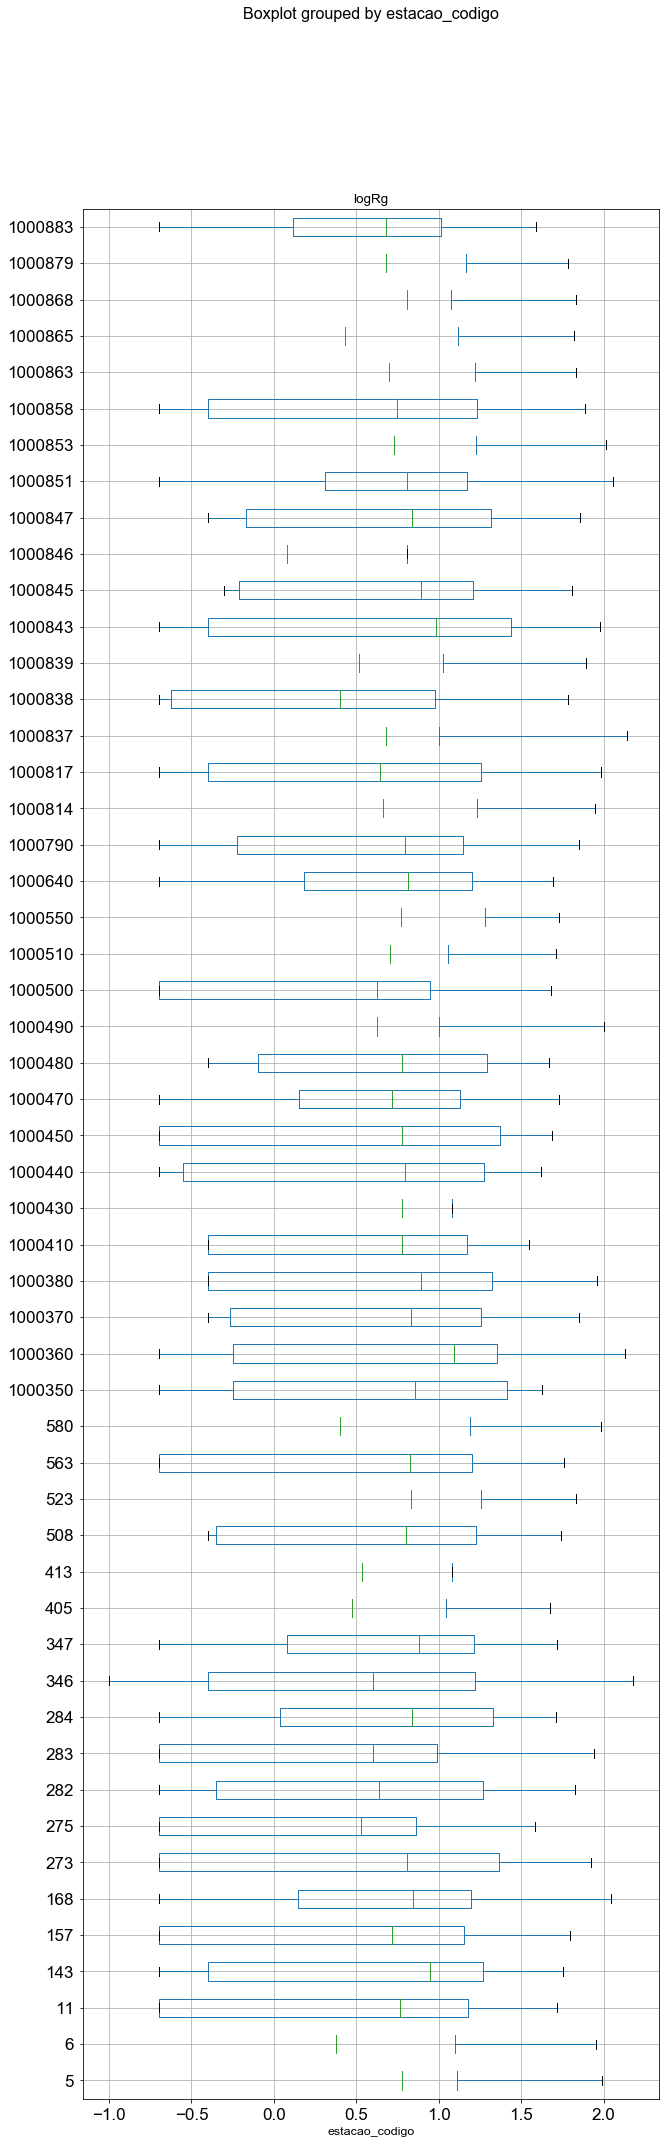

In [61]:
station_1d.dropna().boxplot(by='estacao_codigo',column='logRg',figsize=(10,35),fontsize=17,vert=False,showmeans=True)

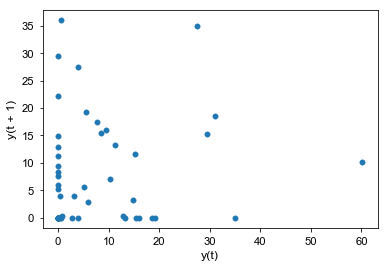

In [62]:
lag_plot(station_1d.loc[1000410,:].Rg_mm_10)

## Bias and RMSE

In [63]:
n=station_1h.query('Rg_mm_10>@thr and Rspol>@thr').Rg_mm_10.count()
soma=((station_1h.query('Rg_mm_10>@thr and Rspol>@thr').Rg_mm_10-station_1h.query('Rg_mm_10>@thr and Rspol>@thr').Rspol)**2).sum()
s_soma=(station_1h.query('Rg_mm_10>@thr and Rspol>@thr').Rg_mm_10-station_1h.query('Rg_mm_10>@thr and Rspol>@thr').Rspol).sum()
bias_1h_kdp=s_soma/(n-1)
print('1h DPSRI-gauges: bias = '+str(bias_1h_kdp))
rmse_1h_kdp=np.sqrt(soma/(n-1))
print('1h DPSRI-gauges: RMSE = '+str(rmse_1h_kdp))

1h DPSRI-gauges: bias = 1.03996645618
1h DPSRI-gauges: RMSE = 5.73405617653


In [64]:
n=station_1d[(station_1d.Rg_mm_10>thr) & (station_1d.Rspol>thr)].Rg_mm_10.count()
soma=((station_1d[(station_1d.Rg_mm_10>thr) &
           (station_1d.Rspol>thr)].Rg_mm_10-station_1d[(station_1d.Rg_mm_10>thr) &
                                                    (station_1d.Rspol>thr)].Rspol)**2).sum()
s_soma=(station_1d[(station_1d.Rg_mm_10>thr) &
           (station_1d.Rspol>thr)].Rg_mm_10-station_1d[(station_1d.Rg_mm_10>thr) &
                                                    (station_1d.Rspol>thr)].Rspol).sum()
bias_1d_kdp=s_soma/(n-1)
print('1d DPSRI-gaugues: bias = '+str(bias_1d_kdp))
rmse_1d_kdp=np.sqrt(soma/(n-1))
print('1d DPSRI-gauges: RMSE = '+str(rmse_1d_kdp))

1d DPSRI-gaugues: bias = 6.31096672996
1d DPSRI-gauges: RMSE = 14.9789922198


## Gauges vs Radar rainfall regressions

y = 0.303887346069 x + 2.1676719429


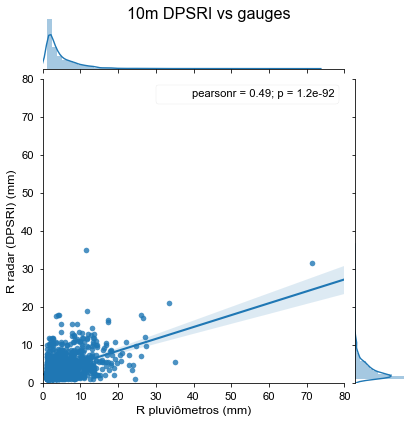

In [65]:
p1=(sns.jointplot(x='Rg_mm_10',y='Rspol',data=station_10m.query('Rg_mm_10>@thr & Rspol>@thr').dropna(axis=0),kind='reg',
                 xlim=(0,80),ylim=(0,80)))
p1.set_axis_labels("R pluviômetros (mm)", "R radar (DPSRI) (mm)")
p1.fig.suptitle('10m DPSRI vs gauges')
p1.savefig('spol_10m.svg')
p1.savefig('spol_10m.png')
fit=np.polyfit(station_10m[(station_10m.Rg_mm_10>thr) & (station_10m.Rspol>thr)].Rg_mm_10,
               station_10m[(station_10m.Rg_mm_10>thr) & (station_10m.Rspol>thr)].Rspol,deg=1)
print('y = '+str(fit[0])+' x'+' + '+str(fit[1]))

y = 0.569972015221 x + 1.82107548051


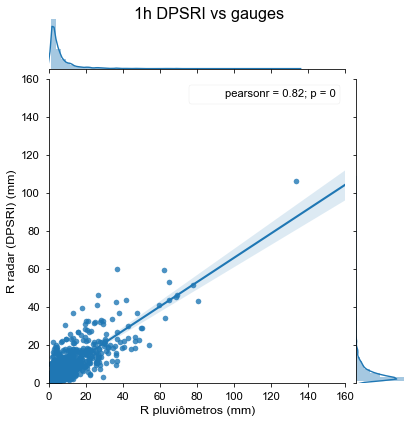

In [66]:
p1=(sns.jointplot(x='Rg_mm_10',y='Rspol',data=station_1h[(station_1h.Rg_mm_10>thr) & (station_1h.Rspol>thr)].dropna(axis=0),kind='reg',
                 xlim=(0,160),ylim=(0,160)))
p1.set_axis_labels("R pluviômetros (mm)", "R radar (DPSRI) (mm)")
p1.fig.suptitle('1h DPSRI vs gauges')
p1.savefig('spol_1H.svg')
p1.savefig('spol_1H.png')
fit=np.polyfit(station_1h[(station_1h.Rg_mm_10>thr) & (station_1h.Rspol>thr)].Rg_mm_10,
               station_1h[(station_1h.Rg_mm_10>thr) & (station_1h.Rspol>thr)].Rspol,deg=1)
print('y = '+str(fit[0])+' x'+' + '+str(fit[1]))

y = 0.417195509241 x + 4.38204018087


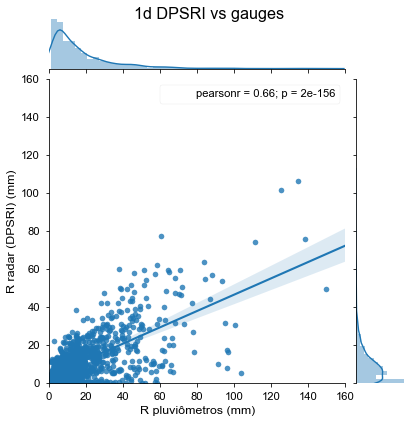

In [67]:
p2=(sns.jointplot(x='Rg_mm_10',y='Rspol',data=station_1d.query('Rg_mm_10>@thr & (Rspol>@thr | lag1_rg>-30 | lagneg1_rg<30)').dropna(axis=0),kind='reg',
                 xlim=(0,160),ylim=(0,160)))
p2.set_axis_labels("R pluviômetros (mm)", "R radar (DPSRI) (mm)")
fit=np.polyfit(station_1d[(station_1d.Rg_mm_10>thr) & (station_1d.Rspol>thr)].Rg_mm_10,
               station_1d[(station_1d.Rg_mm_10>thr) & (station_1d.Rspol>thr)].Rspol,deg=1)
print('y = '+str(fit[0])+' x'+' + '+str(fit[1]))
p2.fig.suptitle('1d DPSRI vs gauges')
p2.savefig('spol_1d.svg')
p2.savefig('spol_1d.png')

y = 0.417195509241 x + 4.38204018087


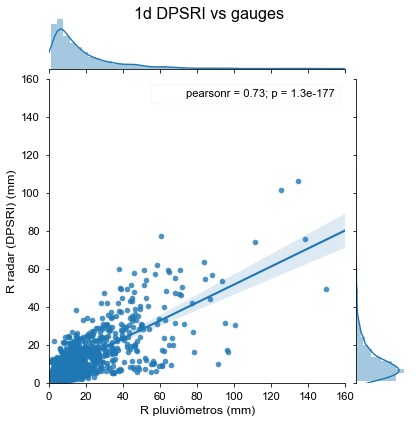

In [68]:
p2=(sns.jointplot(x='Rg_mm_10',y='Rspol',data=station_1d.query('Rg_mm_10>@thr & Rspol>@thr & Rg_mm_10/Rspol<10').dropna(axis=0),kind='reg',
                 xlim=(0,160),ylim=(0,160)))
p2.set_axis_labels("R pluviômetros (mm)", "R radar (DPSRI) (mm)")
fit=np.polyfit(station_1d[(station_1d.Rg_mm_10>thr) & (station_1d.Rspol>thr)].Rg_mm_10,
               station_1d[(station_1d.Rg_mm_10>thr) & (station_1d.Rspol>thr)].Rspol,deg=1)
print('y = '+str(fit[0])+' x'+' + '+str(fit[1]))
p2.fig.suptitle('1d DPSRI vs gauges')
#p2.savefig('spol_1d.svg')
#p2.savefig('spol_1d.png')

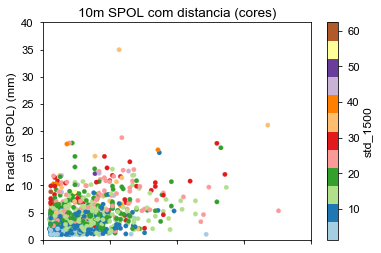

In [364]:
p3=station_10m.query('Rg_mm_10>@thr & Rspol>@thr').dropna(axis=0).plot.scatter(y='Rspol',x='Rg_mm_10',c='std_1500',cmap='Paired',
                                                               xlim=(0,40),
                                                               ylim=(0,40),title='10m SPOL com distancia (cores)')
p3.set_xlabel("R pluviômetros (mm)")
p3.set_ylabel("R radar (SPOL) (mm)")
p3.figure.savefig('spol_10m_distância.png')

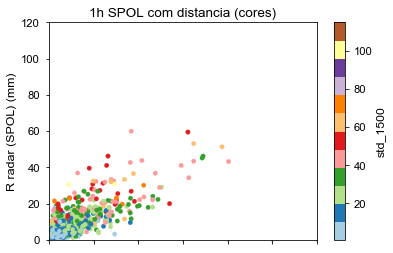

In [365]:
p3=station_1h.query('Rg_mm_10>@thr & Rspol>@thr').dropna(axis=0).plot.scatter(y='Rspol',x='Rg_mm_10',c='std_1500',cmap='Paired',
                                                               xlim=(0,120),
                                                               ylim=(0,120),title='1h SPOL com distancia (cores)')
p3.set_xlabel("R pluviômetros (mm)")
p3.set_ylabel("R radar (SPOL) (mm)")
p3.figure.savefig('spol_1h_distância.png')

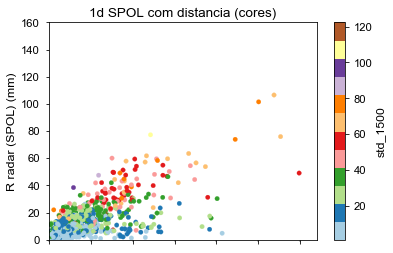

In [366]:
p3=station_1d.query('Rg_mm_10>@thr & Rspol>@thr').dropna(axis=0).plot.scatter(y='Rspol',x='Rg_mm_10',c='std_1500',cmap='Paired',
                                                               xlim=(0,160),
                                                               ylim=(0,160),title='1d SPOL com distancia (cores)')
p3.set_xlabel("R pluviômetros (mm)")
p3.set_ylabel("R radar (SPOL) (mm)")
p3.figure.savefig('spol_1d_distância.png')

y = 0.366357400286 x + 2.13266260081
y = 0.260733481739 x + 2.39801431248
y = 0.261575849977 x + 2.3148981937
y = 0.315053456976 x + 2.12134091494
y = 0.303887346069 x + 2.1676719429


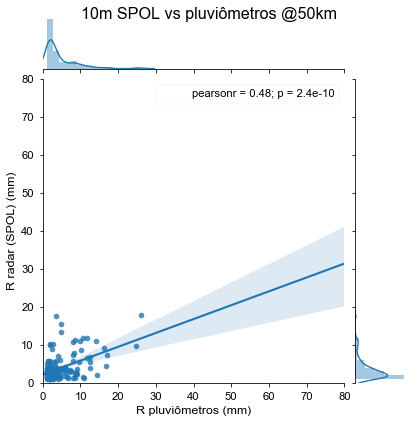

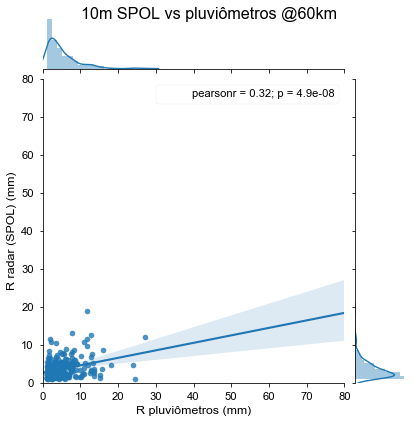

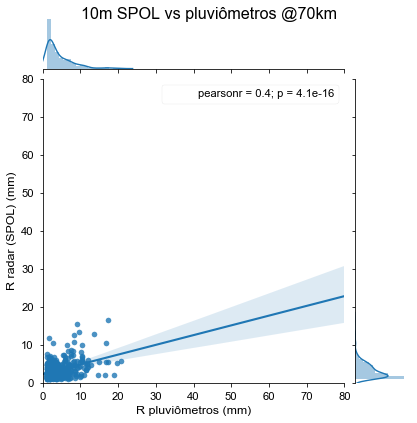

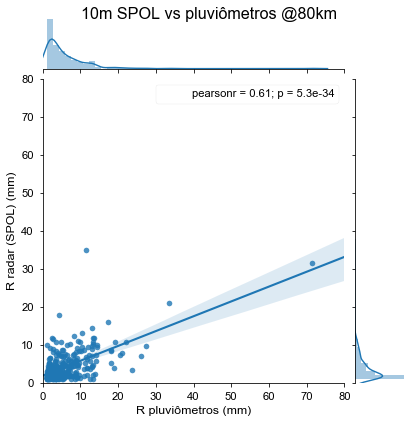

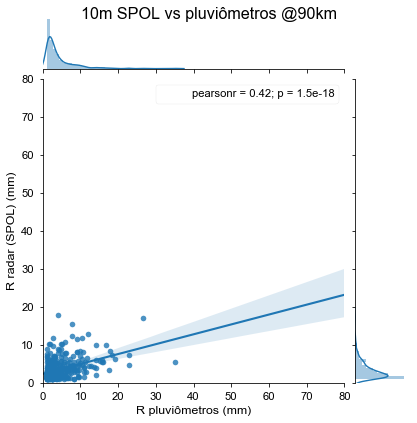

In [72]:
for dist in [50,60,70,80,90]:
    p2=(sns.jointplot(x='Rg_mm_10',y='Rspol',data=station_10m.query('Rg_mm_10>@thr & Rspol>@thr & r_spol<@dist & r_spol>@dist-10').dropna(axis=0),kind='reg',
                 xlim=(0,80),ylim=(0,80)))
    p2.set_axis_labels("R pluviômetros (mm)", "R radar (SPOL) (mm)")
    fit=np.polyfit(station_10m.query('Rg_mm_10>@thr & Rspol>@thr & r_spol<@dist').Rg_mm_10,
               station_10m.query('Rg_mm_10>@thr & Rspol>@thr & r_spol<@dist').Rspol,deg=1)
    print('y = '+str(fit[0])+' x'+' + '+str(fit[1]))
    p2.fig.suptitle('10m SPOL vs pluviômetros @'+str(dist)+'km')
    p2.savefig('spol_10m_'+str(dist)+'km.png')

y = 0.776570133636 x + 0.981609456452
y = 0.586685651124 x + 1.79733903899
y = 0.540605952405 x + 1.98616461254
y = 0.578596332972 x + 1.68137886943
y = 0.569972015221 x + 1.82107548051


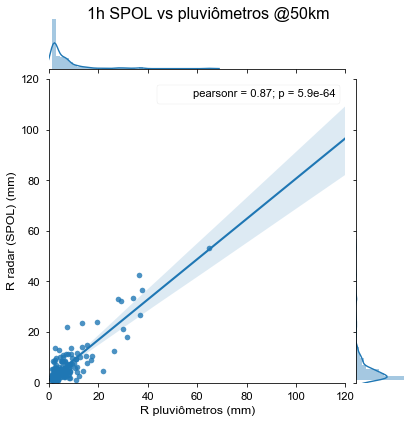

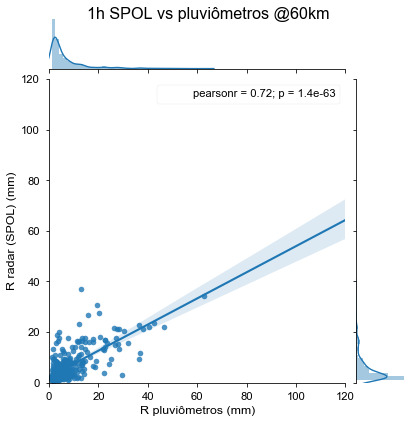

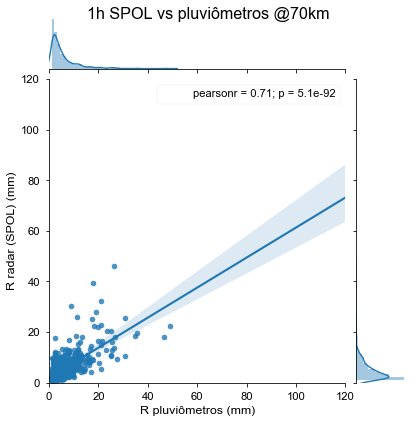

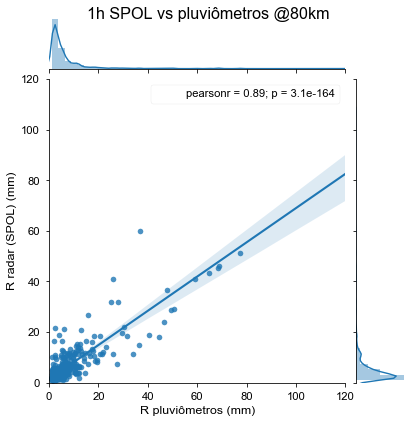

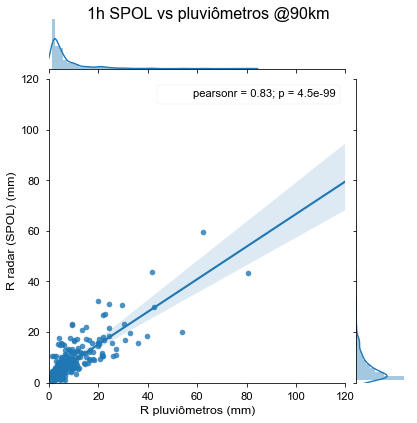

In [ ]:
for dist in [50,60,70,80,90]:
    p2=(sns.jointplot(x='Rg_mm_10',y='Rspol',data=station_1h.query('Rg_mm_10>@thr & Rspol>@thr & r_spol<@dist & r_spol>@dist-10').dropna(axis=0),kind='reg',
                 xlim=(0,120),ylim=(0,120)))
    p2.set_axis_labels("R pluviômetros (mm)", "R radar (SPOL) (mm)")
    fit=np.polyfit(station_1h.query('Rg_mm_10>@thr & Rspol>@thr & r_spol<@dist').Rg_mm_10,
               station_1h.query('Rg_mm_10>@thr & Rspol>@thr & r_spol<@dist').Rspol,deg=1)
    print('y = '+str(fit[0])+' x'+' + '+str(fit[1]))
    p2.fig.suptitle('1h SPOL vs pluviômetros @'+str(dist)+'km')
    p2.savefig('spol_1h_'+str(dist)+'km.png')

y = 0.530784911121 x + 3.52923461345
y = 0.386942921478 x + 5.00464669984
y = 0.387812202811 x + 4.75118502629
y = 0.429166890191 x + 4.02680255213
y = 0.417195509241 x + 4.38204018087


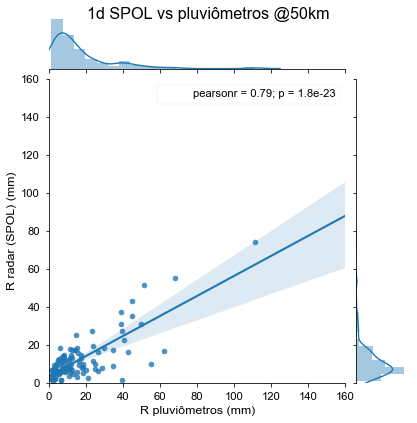

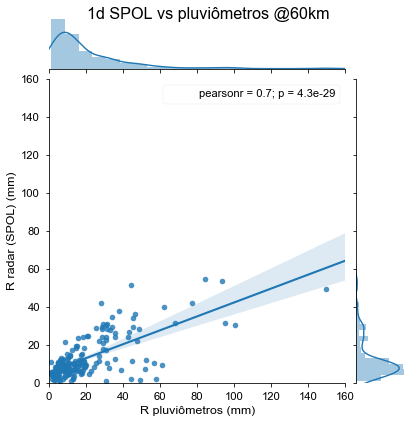

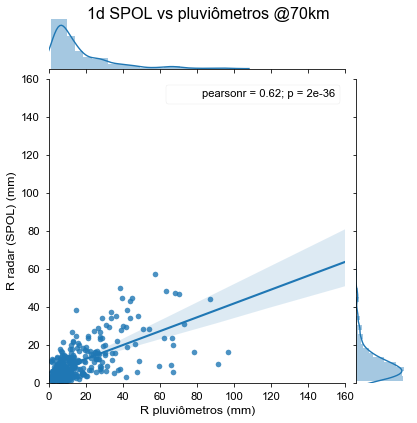

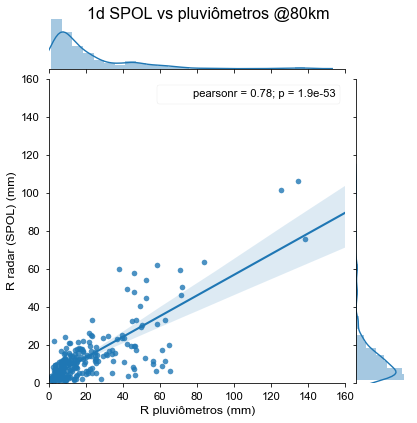

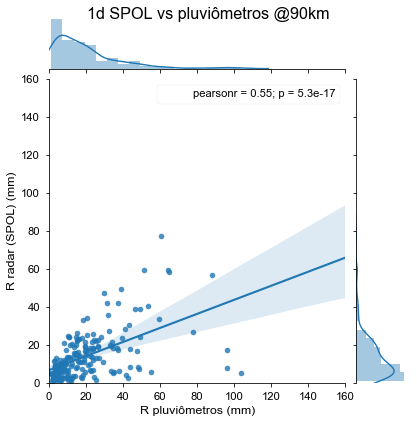

In [107]:
for dist in [50,60,70,80,90]:
    p2=(sns.jointplot(x='Rg_mm_10',y='Rspol',data=station_1d.query('Rg_mm_10>@thr & Rspol>@thr & r_spol<@dist & r_spol>@dist-10').dropna(axis=0),kind='reg',
                 xlim=(0,160),ylim=(0,160)))
    p2.set_axis_labels("R pluviômetros (mm)", "R radar (SPOL) (mm)")
    fit=np.polyfit(station_1d.query('Rg_mm_10>@thr & Rspol>@thr & r_spol<@dist').Rg_mm_10,
               station_1d.query('Rg_mm_10>@thr & Rspol>@thr & r_spol<@dist').Rspol,deg=1)
    print('y = '+str(fit[0])+' x'+' + '+str(fit[1]))
    p2.fig.suptitle('1d SPOL vs pluviômetros @'+str(dist)+'km')
    p2.savefig('spol_1d_'+str(dist)+'km.png')

y = 0.287513082619 x + 2.34541183181
y = 0.2922075538 x + 2.65649557534
y = 0.313291199694 x + 2.54444735428
y = 0.308862519008 x + 2.49246862099
y = 0.308375004 x + 2.43030535989
y = 0.313319790623 x + 2.3739882268
y = 0.29749231087 x + 2.39184879358
y = 0.302965680456 x + 2.30289082647
y = 0.30580093866 x + 2.22104219479
y = 0.303887346069 x + 2.1676719429


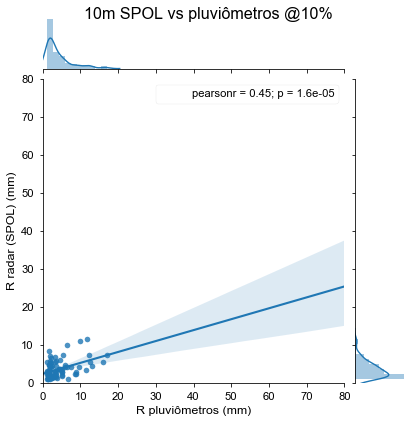

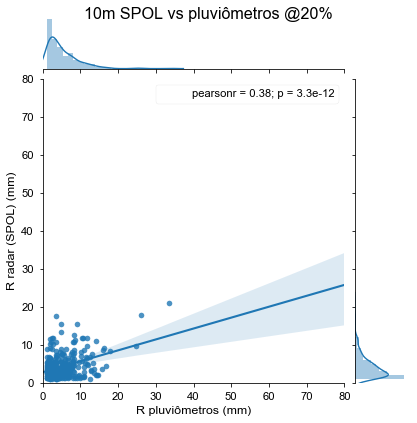

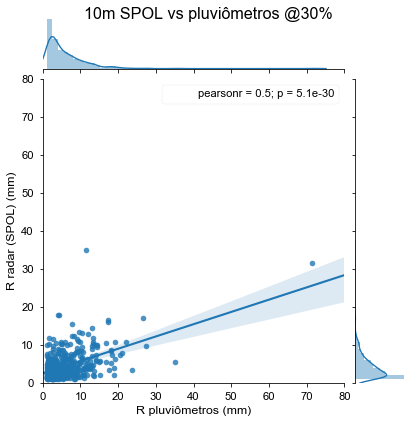

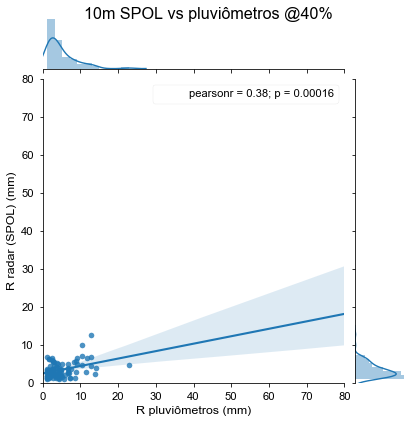

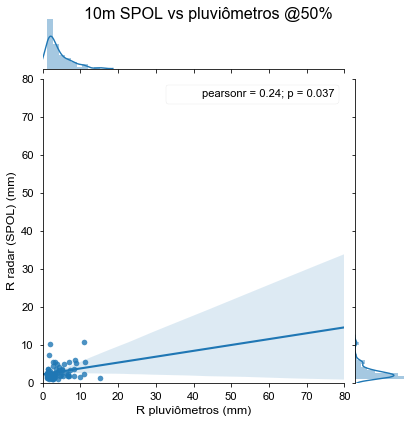

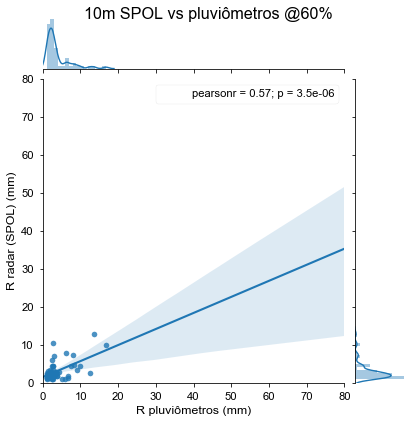

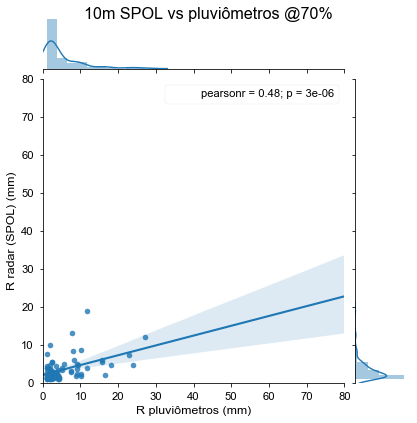

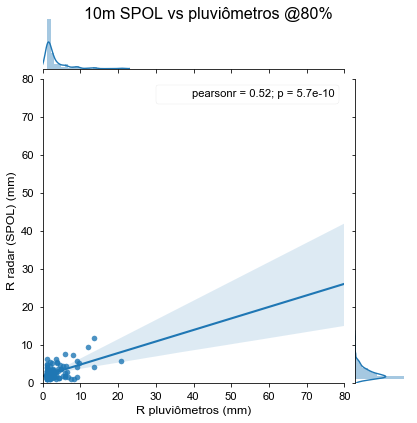

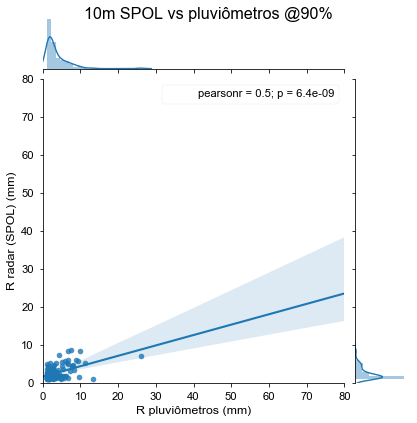

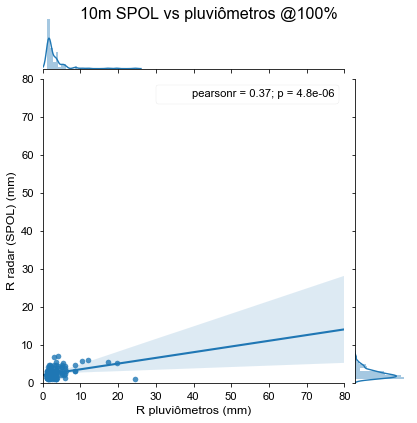

In [108]:
for frac in range(10,110,10):
    p2=(sns.jointplot(x='Rg_mm_10',y='Rspol',data=station_10m.query('Rg_mm_10>@thr & Rspol>@thr & area_chuva<@frac & area_chuva>@frac-10').dropna(axis=0),kind='reg',
                 xlim=(0,80),ylim=(0,80)))
    p2.set_axis_labels("R pluviômetros (mm)", "R radar (SPOL) (mm)")
    fit=np.polyfit(station_10m.query('Rg_mm_10>@thr & Rspol>@thr & area_chuva<@frac').Rg_mm_10,
               station_10m.query('Rg_mm_10>@thr & Rspol>@thr & area_chuva<@frac').Rspol,deg=1)
    print('y = '+str(fit[0])+' x'+' + '+str(fit[1]))
    p2.fig.suptitle('10m SPOL vs pluviômetros @'+str(frac)+'%')
    p2.savefig('spol_10m_'+str(frac)+'_frac.png')

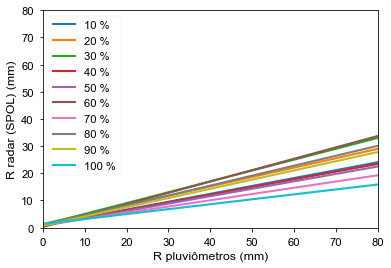

In [374]:
fig,ax=plt.subplots()
ax.set(xlim=(0,80),ylim=(0,80))
for frac in range(10,110,10):
    p3=sns.regplot(x='Rg_mm_10',y='Rspol',data=station_10m.query('Rg_mm_10>@thr & Rspol_1500>@thr & area_chuva<@frac & area_chuva>@frac-10').dropna(axis=0),
                  scatter=False,ci=True,label=str(frac)+' %')
    p3.set(xlabel="R pluviômetros (mm)", ylabel="R radar (SPOL) (mm)")
    plt.legend()
    plt.savefig('spol_10m_fracs_retas.pdf',bbox_inches='tight', pad_inches=0)

y = 0.421984434513 x + 2.35493273451
y = 0.647452301049 x + 2.21219265415
y = 0.669399919977 x + 1.70840172075
y = 0.651925099647 x + 1.48020610948
y = 0.616201611121 x + 1.55058362268
y = 0.582125033047 x + 1.49566008312
y = 0.579099559912 x + 1.59590911184
y = 0.575253831799 x + 1.69878136833
y = 0.572565954761 x + 1.72728046061
y = 0.569972015221 x + 1.82107548051


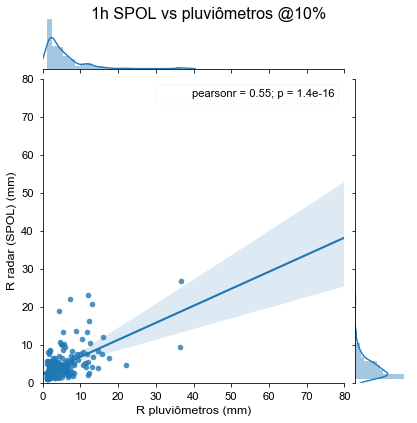

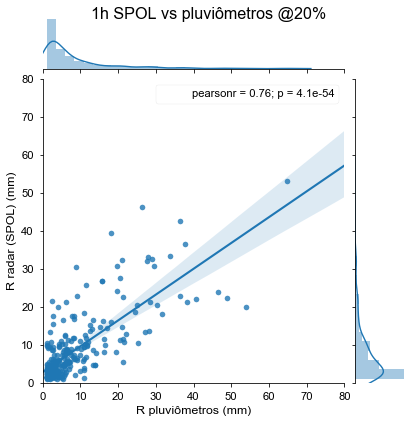

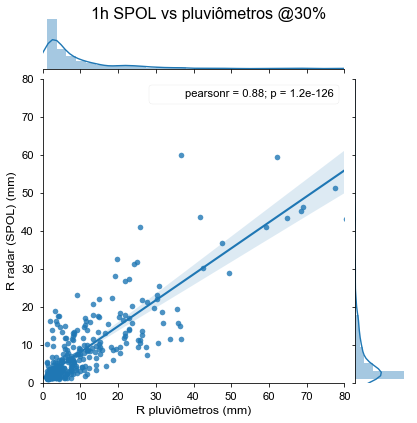

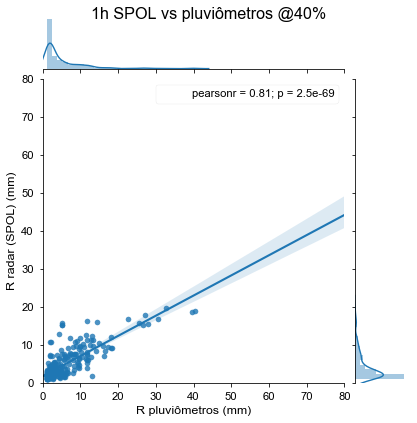

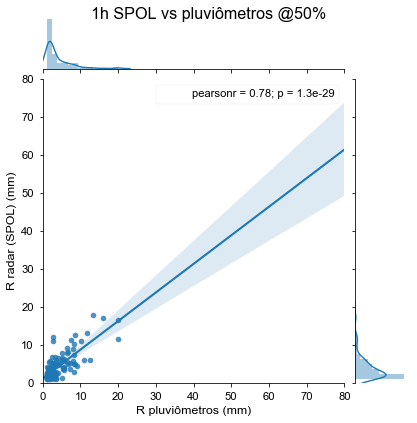

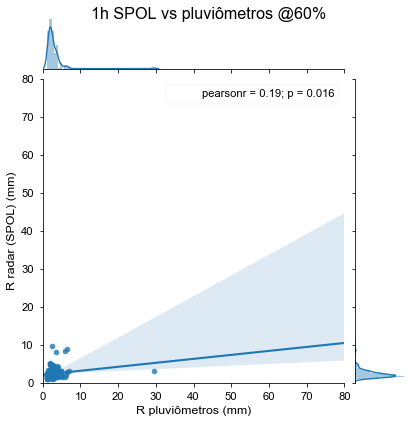

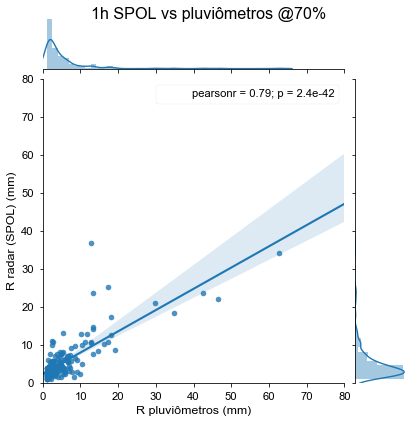

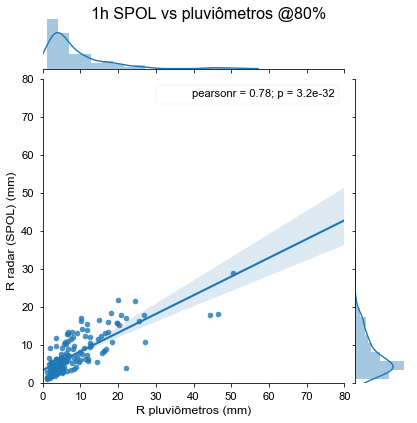

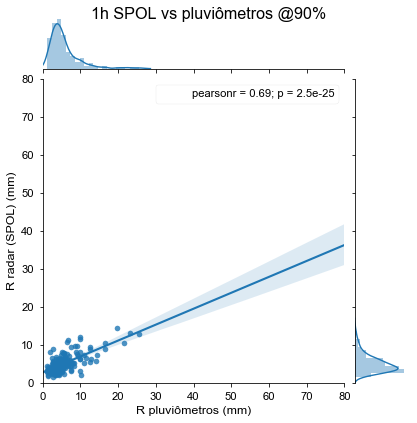

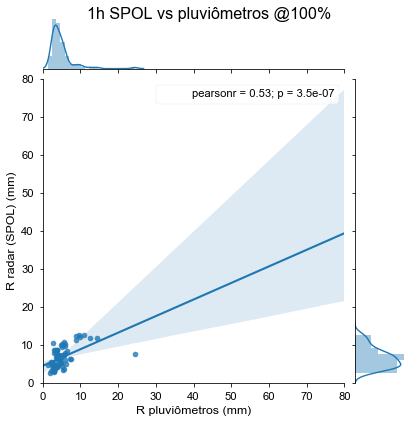

In [109]:
for frac in range(10,110,10):
    p2=(sns.jointplot(x='Rg_mm_10',y='Rspol',data=station_1h.query('Rg_mm_10>@thr & Rspol>@thr & area_chuva<@frac & area_chuva>@frac-10').dropna(axis=0),kind='reg',
                 xlim=(0,80),ylim=(0,80)))
    p2.set_axis_labels("R pluviômetros (mm)", "R radar (SPOL) (mm)")
    fit=np.polyfit(station_1h.query('Rg_mm_10>@thr & Rspol>@thr & area_chuva<@frac').Rg_mm_10,
               station_1h.query('Rg_mm_10>@thr & Rspol>@thr & area_chuva<@frac').Rspol,deg=1)
    print('y = '+str(fit[0])+' x'+' + '+str(fit[1]))
    p2.fig.suptitle('1h SPOL vs pluviômetros @'+str(frac)+'%')
    p2.savefig('spol_1h_'+str(frac)+'_frac.png')

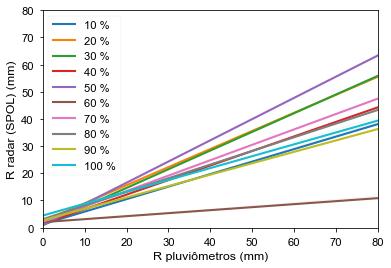

In [375]:
fig,ax=plt.subplots()
ax.set(xlim=(0,80),ylim=(0,80))
for frac in range(10,110,10):
    p3=sns.regplot(x='Rg_mm_10',y='Rspol',data=station_1h.query('Rg_mm_10>@thr & Rspol_1500>@thr & area_chuva<@frac & area_chuva>@frac-10').dropna(axis=0),
                  scatter=False,ci=True,label=str(frac)+' %')
    p3.set(xlabel="R pluviômetros (mm)", ylabel="R radar (SPOL) (mm)")
    plt.legend()
    plt.savefig('spol_1h_fracs_retas.pdf',bbox_inches='tight', pad_inches=0)

y = 0.380318680672 x + 2.17872537464
y = 0.396779630409 x + 4.25070364682
y = 0.422806982374 x + 4.36662447739
y = 0.41539443949 x + 4.4267618172
y = 0.416623805192 x + 4.37017394262
y = 0.416669873816 x + 4.37028099785
y = 0.417190134055 x + 4.38164438415
y = 0.417195509241 x + 4.38204018087


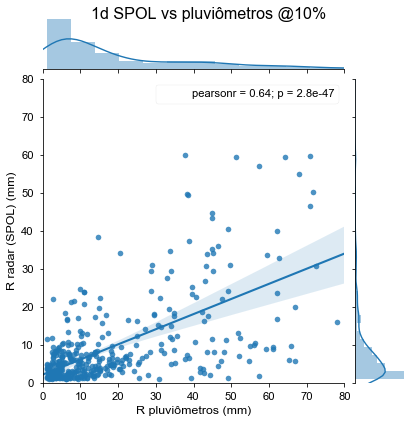

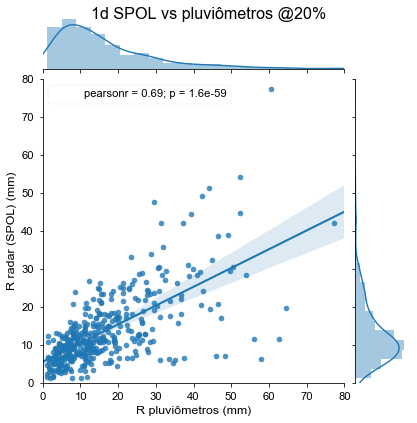

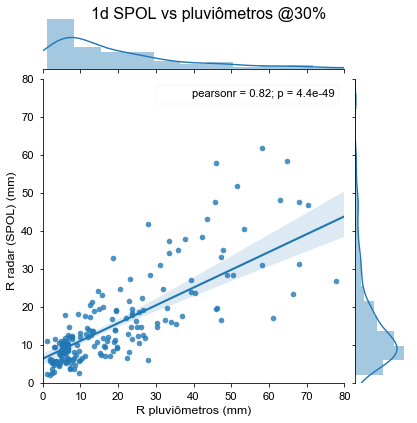

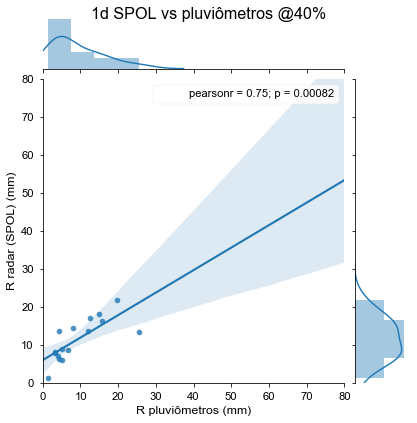

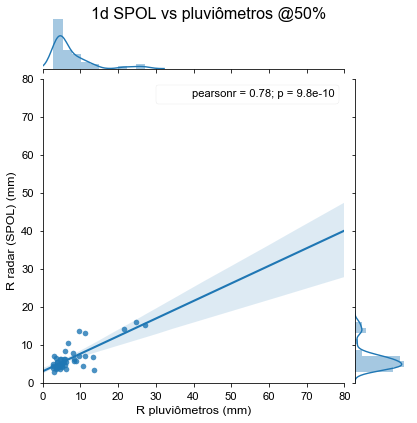

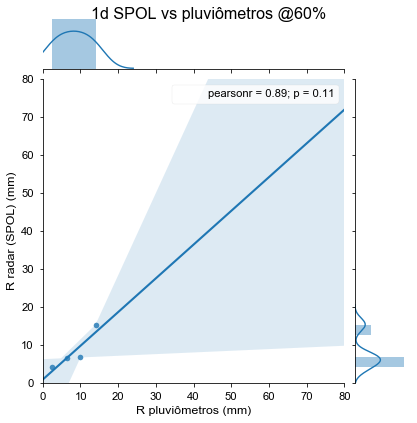

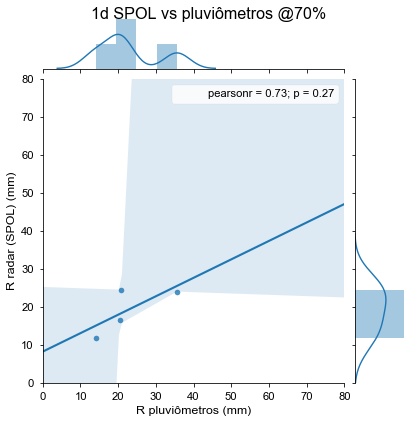

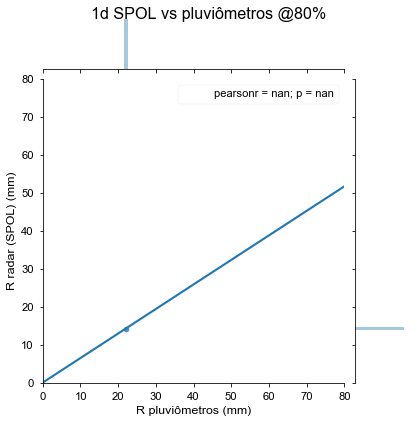

In [110]:
for frac in range(10,90,10):
    p2=(sns.jointplot(x='Rg_mm_10',y='Rspol',data=station_1d.query('Rg_mm_10>@thr & Rspol>@thr & area_chuva<@frac & area_chuva>@frac-10').dropna(axis=0),kind='reg',
                 xlim=(0,80),ylim=(0,80)))
    p2.set_axis_labels("R pluviômetros (mm)", "R radar (SPOL) (mm)")
    fit=np.polyfit(station_1d.query('Rg_mm_10>@thr & Rspol>@thr & area_chuva<@frac').Rg_mm_10,
               station_1d.query('Rg_mm_10>@thr & Rspol>@thr & area_chuva<@frac').Rspol,deg=1)
    print('y = '+str(fit[0])+' x'+' + '+str(fit[1]))
    p2.fig.suptitle('1d SPOL vs pluviômetros @'+str(frac)+'%')
    p2.savefig('spol_1d_'+str(frac)+'_frac.png')

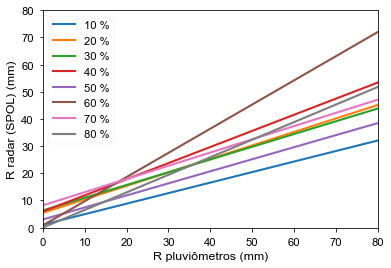

In [377]:
fig,ax=plt.subplots()
ax.set(xlim=(0,80),ylim=(0,80))
for frac in range(10,90,10):
    p3=sns.regplot(x='Rg_mm_10',y='Rspol',data=station_1d.query('Rg_mm_10>@thr & Rspol_1500>@thr & area_chuva<@frac & area_chuva>@frac-10').dropna(axis=0),
                  scatter=False,ci=True,label=str(frac)+' %')
    p3.set(xlabel="R pluviômetros (mm)", ylabel="R radar (SPOL) (mm)")
    plt.legend()
    plt.savefig('spol_1d_fracs_retas.pdf',bbox_inches='tight', pad_inches=0)

y = 0.366357400286 x + 2.13266260081
y = 0.260733481739 x + 2.39801431248
y = 0.261575849977 x + 2.3148981937
y = 0.315053456976 x + 2.12134091494
y = 0.303887346069 x + 2.1676719429


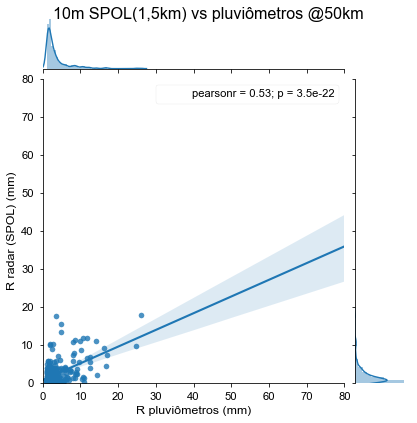

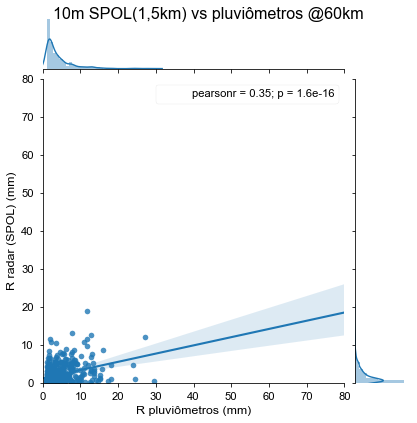

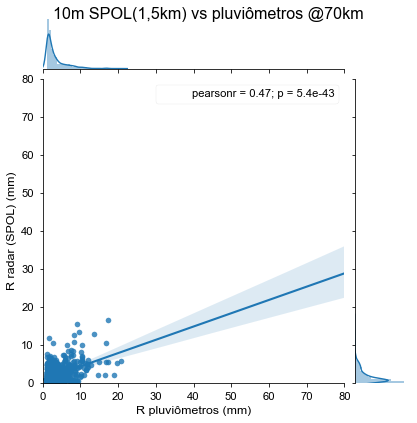

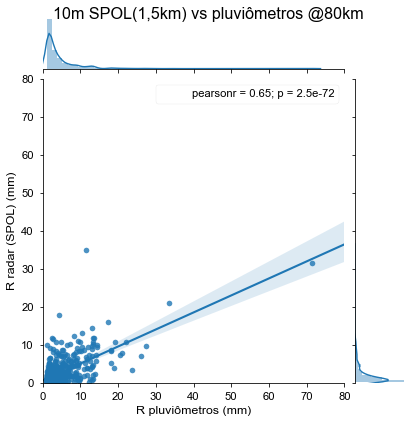

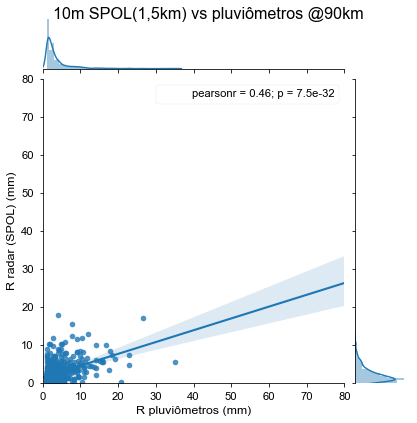

In [278]:
for dist in [50,60,70,80,90]:
    p2=(sns.jointplot(x='Rg_mm_10',y='Rspol',data=station_10m.query('Rg_mm_10>@thr & Rspol_1500>@thr & r_spol<@dist & r_spol>@dist-10').dropna(axis=0),kind='reg',
                 xlim=(0,80),ylim=(0,80)))
    p2.set_axis_labels("R pluviômetros (mm)", "R radar (SPOL) (mm)")
    fit=np.polyfit(station_10m.query('Rg_mm_10>@thr & Rspol>@thr & r_spol<@dist').Rg_mm_10,
               station_10m.query('Rg_mm_10>@thr & Rspol>@thr & r_spol<@dist').Rspol,deg=1)
    print('y = '+str(fit[0])+' x'+' + '+str(fit[1]))
    p2.fig.suptitle('10m SPOL(1,5km) vs pluviômetros @'+str(dist)+'km')
    p2.savefig('spol_1500_10m_'+str(dist)+'km.png')

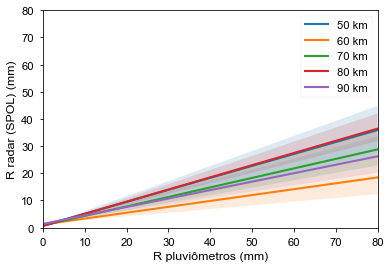

In [279]:
fig,ax=plt.subplots()
ax.set(xlim=(0,80),ylim=(0,80))
for dist in [50,60,70,80,90]:
    p3=sns.regplot(x='Rg_mm_10',y='Rspol',data=station_10m.query('Rg_mm_10>@thr & Rspol_1500>@thr & r_spol<@dist & r_spol>@dist-10').dropna(axis=0),
                  scatter=False,label=str(dist)+' km')
    p3.set(xlabel="R pluviômetros (mm)", ylabel="R radar (SPOL) (mm)")
    plt.legend()
    plt.savefig('spol_10m_1500_dists_retas.pdf',bbox_inches='tight', pad_inches=0)

y = 0.776570133636 x + 0.981609456452
y = 0.586685651124 x + 1.79733903899
y = 0.540605952405 x + 1.98616461254
y = 0.578596332972 x + 1.68137886943
y = 0.569972015221 x + 1.82107548051


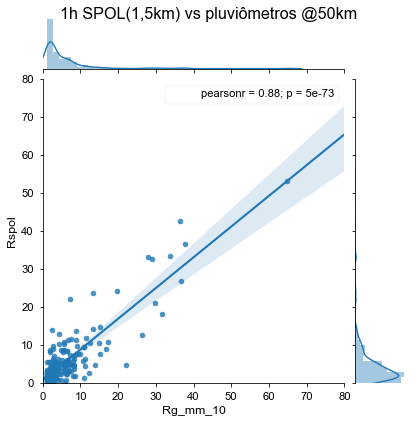

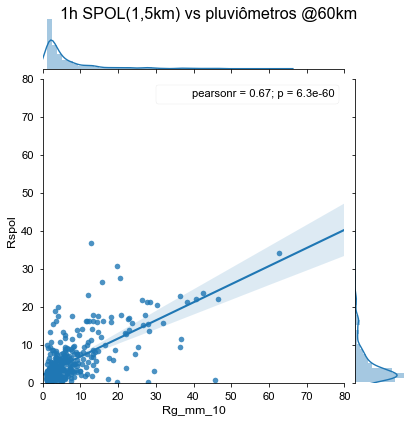

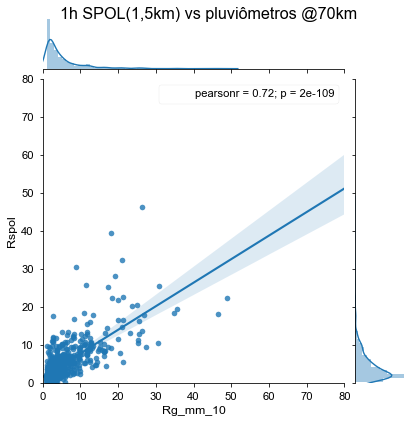

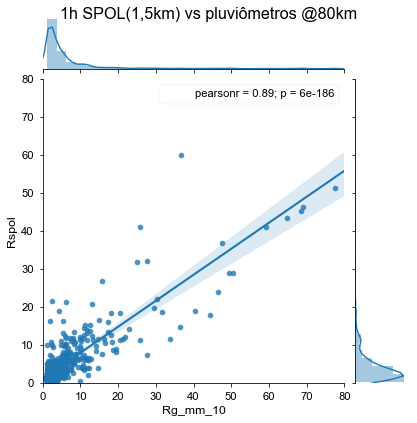

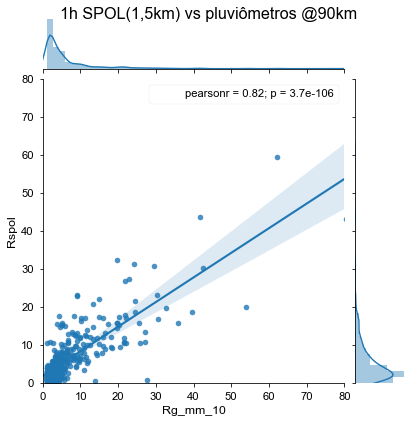

In [281]:
for dist in [50,60,70,80,90]:
    p2=(sns.jointplot(x='Rg_mm_10',y='Rspol',data=station_1h.query('Rg_mm_10>@thr & Rspol_1500>@thr & r_spol<@dist & r_spol>@dist-10').dropna(axis=0),kind='reg',
                 xlim=(0,80),ylim=(0,80)))
    #p2=(sns.lmplot(x='Rg_mm_10',y='Rspol',data=station_1h.query('Rg_mm_10>@thr & Rspol_1500>@thr & r_spol<@dist & r_spol>@dist-10').dropna(axis=0),
    #              x_bins=range(0,82,2),x_ci='sd')).set(xlim=(0,80),ylim=(0,80))
    #p2.set_axis_labels("R pluviômetros (mm)", "R radar (SPOL) (mm)")
    fit=np.polyfit(station_1h.query('Rg_mm_10>@thr & Rspol>@thr & r_spol<@dist').Rg_mm_10,
               station_1h.query('Rg_mm_10>@thr & Rspol>@thr & r_spol<@dist').Rspol,deg=1)
    print('y = '+str(fit[0])+' x'+' + '+str(fit[1]))
    p2.fig.suptitle('1h SPOL(1,5km) vs pluviômetros @'+str(dist)+'km')
    p2.savefig('spol_1500_1h_'+str(dist)+'km.png')

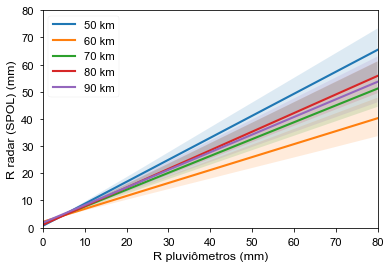

In [280]:
fig,ax=plt.subplots()
ax.set(xlim=(0,80),ylim=(0,80))
for dist in [50,60,70,80,90]:
    p3=sns.regplot(x='Rg_mm_10',y='Rspol',data=station_1h.query('Rg_mm_10>@thr & Rspol_1500>@thr & r_spol<@dist & r_spol>@dist-10').dropna(axis=0),
                  scatter=False,label=str(dist)+' km')
    p3.set(xlabel="R pluviômetros (mm)", ylabel="R radar (SPOL) (mm)")
    plt.legend()
    plt.savefig('spol_1h_1500_dists_retas.pdf',bbox_inches='tight', pad_inches=0)

y = 0.530784911121 x + 3.52923461345
y = 0.386942921478 x + 5.00464669984
y = 0.387812202811 x + 4.75118502629
y = 0.429166890191 x + 4.02680255213
y = 0.417195509241 x + 4.38204018087


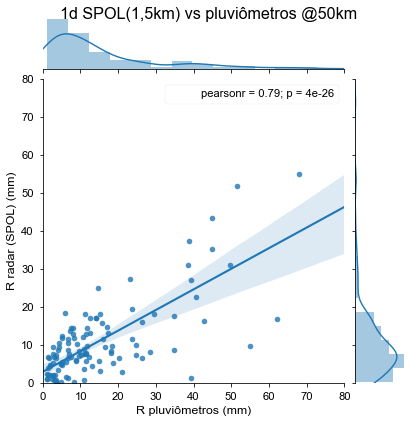

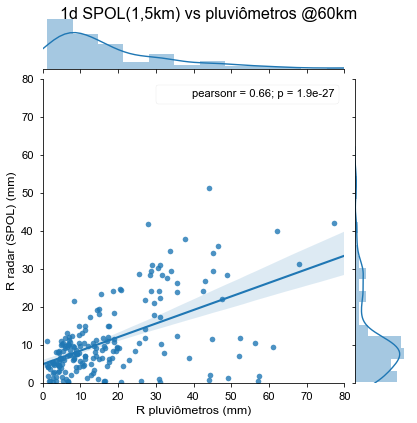

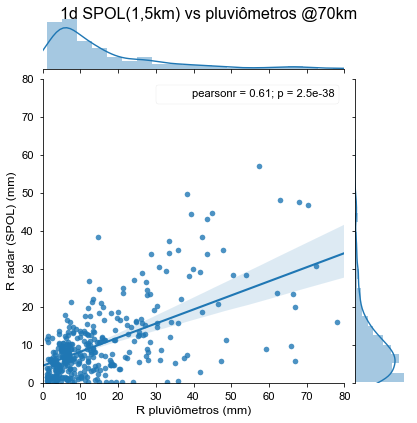

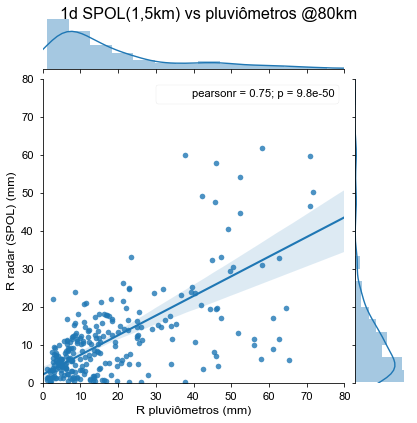

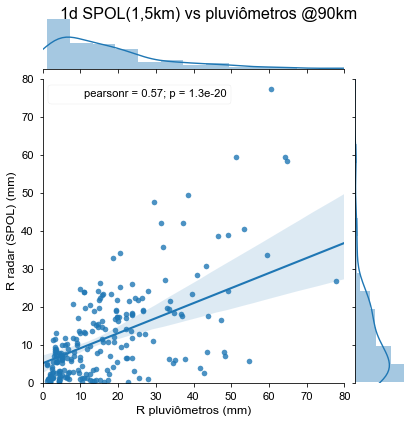

In [244]:
for dist in [50,60,70,80,90]:
    p2=(sns.jointplot(x='Rg_mm_10',y='Rspol',data=station_1d.query('Rg_mm_10>@thr & Rspol_1500>@thr & r_spol<@dist & r_spol>@dist-10').dropna(axis=0),kind='reg',
                 xlim=(0,80),ylim=(0,80)))
    p2.set_axis_labels("R pluviômetros (mm)", "R radar (SPOL) (mm)")
    fit=np.polyfit(station_1d.query('Rg_mm_10>@thr & Rspol>@thr & r_spol<@dist').Rg_mm_10,
               station_1d.query('Rg_mm_10>@thr & Rspol>@thr & r_spol<@dist').Rspol,deg=1)
    print('y = '+str(fit[0])+' x'+' + '+str(fit[1]))
    p2.fig.suptitle('1d SPOL(1,5km) vs pluviômetros @'+str(dist)+'km')
    p2.savefig('spol_1500_1d_'+str(dist)+'km.png')

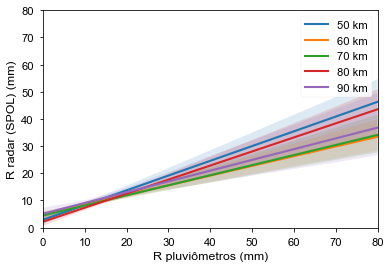

In [283]:
fig,ax=plt.subplots()
ax.set(xlim=(0,80),ylim=(0,80))
for dist in [50,60,70,80,90]:
    p3=sns.regplot(x='Rg_mm_10',y='Rspol',data=station_1d.query('Rg_mm_10>@thr & Rspol_1500>@thr & r_spol<@dist & r_spol>@dist-10').dropna(axis=0),
                  scatter=False,label=str(dist)+' km')
    p3.set(xlabel="R pluviômetros (mm)", ylabel="R radar (SPOL) (mm)")
    plt.legend()
    plt.savefig('spol_1d_1500_dists_retas.pdf',bbox_inches='tight', pad_inches=0)

y = 0.313866915378 x + 0.967220563234
y = 0.142912343539 x + 1.34265113891
y = 0.14406626588 x + 1.29260720714
y = 0.296325562898 x + 0.891935419314
y = 0.122553792876 x + 1.84115711244


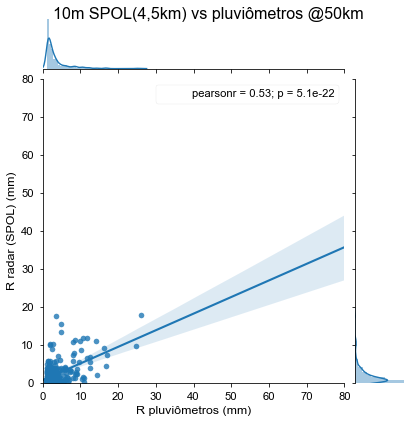

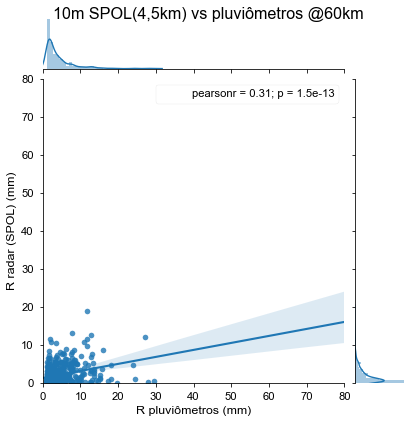

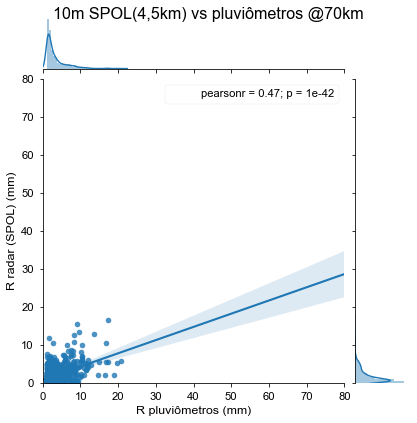

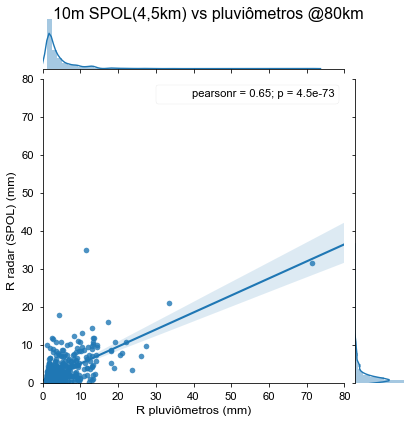

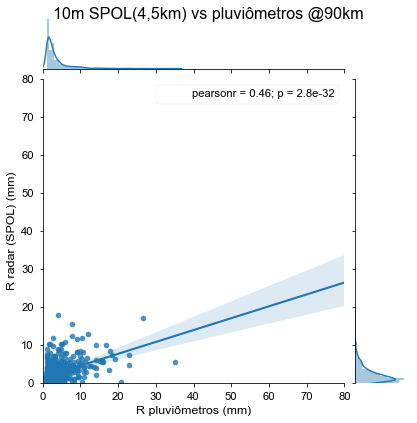

In [187]:
for dist in [50,60,70,80,90]:
    p2=(sns.jointplot(x='Rg_mm_10',y='Rspol',data=station_10m.query('Rg_mm_10>@thr & Rspol_4500>@thr & r_spol<@dist & r_spol>@dist-10').dropna(axis=0),kind='reg',
                 xlim=(0,80),ylim=(0,80)))
    p2.set_axis_labels("R pluviômetros (mm)", "R radar (SPOL) (mm)")
    p2.fig.axes
    fit=np.polyfit(station_10m.query('Rg_mm_10>@thr & Rspol_4500>@thr & r_spol<@dist & r_spol>@dist-10').Rg_mm_10,
               station_10m.query('Rg_mm_10>@thr & Rspol_4500>@thr & r_spol<@dist & r_spol>@dist-10').Rspol,deg=1)
    print('y = '+str(fit[0])+' x'+' + '+str(fit[1]))
    p2.fig.suptitle('10m SPOL(4,5km) vs pluviômetros @'+str(dist)+'km')
    p2.savefig('spol_4500_10m_'+str(dist)+'km.png')

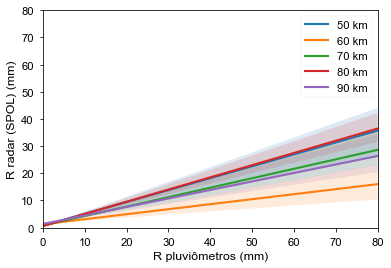

In [380]:
fig,ax=plt.subplots()
ax.set(xlim=(0,80),ylim=(0,80))
for dist in [50,60,70,80,90]:
    p3=sns.regplot(x='Rg_mm_10',y='Rspol',data=station_10m.query('Rg_mm_10>@thr & Rspol_4500>@thr & r_spol<@dist & r_spol>@dist-10').dropna(axis=0),
                  scatter=False,label=str(dist)+' km')
    p3.set(xlabel="R pluviômetros (mm)", ylabel="R radar (SPOL) (mm)")
    plt.legend()
    plt.savefig('spol_10m_4500_dists_retas.pdf',bbox_inches='tight', pad_inches=0)

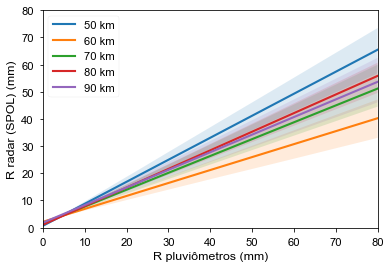

In [378]:
fig,ax=plt.subplots()
ax.set(xlim=(0,80),ylim=(0,80))
for dist in [50,60,70,80,90]:
    p3=sns.regplot(x='Rg_mm_10',y='Rspol',data=station_1h.query('Rg_mm_10>@thr & Rspol_4500>@thr & r_spol<@dist & r_spol>@dist-10').dropna(axis=0),
                  scatter=False,label=str(dist)+' km')
    p3.set(xlabel="R pluviômetros (mm)", ylabel="R radar (SPOL) (mm)")
    plt.legend()
    plt.savefig('spol_1h_4500_dists_retas.pdf',bbox_inches='tight', pad_inches=0)

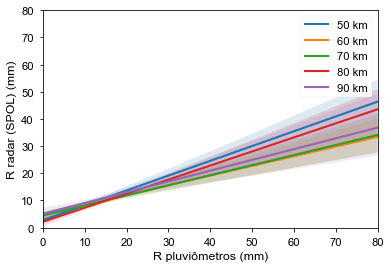

In [379]:
fig,ax=plt.subplots()
ax.set(xlim=(0,80),ylim=(0,80))
for dist in [50,60,70,80,90]:
    p3=sns.regplot(x='Rg_mm_10',y='Rspol',data=station_1d.query('Rg_mm_10>@thr & Rspol_4500>@thr & r_spol<@dist & r_spol>@dist-10').dropna(axis=0),
                  scatter=False,label=str(dist)+' km')
    p3.set(xlabel="R pluviômetros (mm)", ylabel="R radar (SPOL) (mm)")
    plt.legend()
    plt.savefig('spol_1d_4500_dists_retas.pdf',bbox_inches='tight', pad_inches=0)

y = 0.776570133636 x + 0.981609456452
y = 0.586685651124 x + 1.79733903899
y = 0.540605952405 x + 1.98616461254
y = 0.578596332972 x + 1.68137886943
y = 0.569972015221 x + 1.82107548051


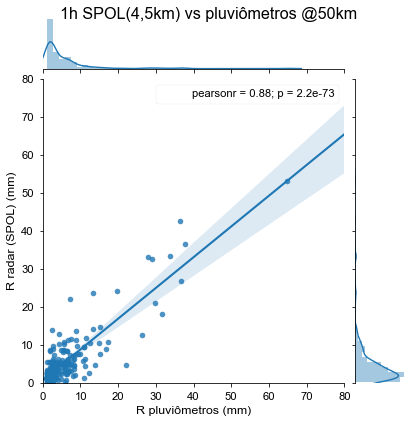

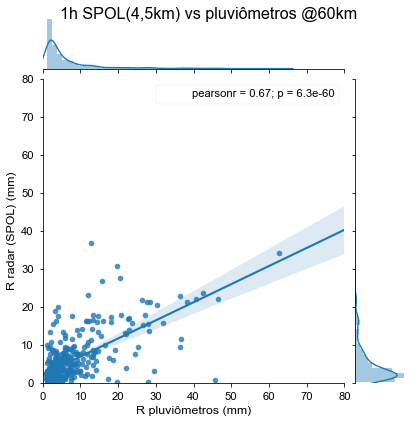

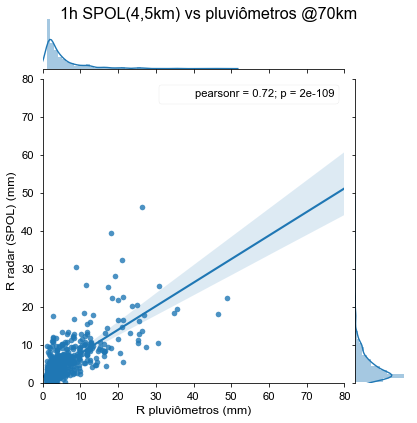

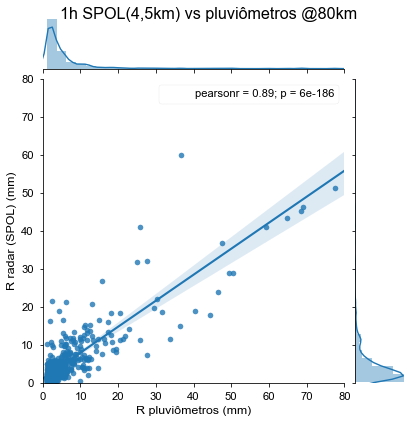

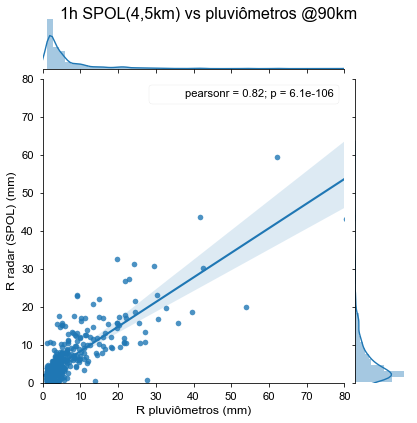

In [115]:
for dist in [50,60,70,80,90]:
    p2=(sns.jointplot(x='Rg_mm_10',y='Rspol',data=station_1h.query('Rg_mm_10>@thr & Rspol_4500>@thr & r_spol<@dist & r_spol>@dist-10').dropna(axis=0),kind='reg',
                 xlim=(0,80),ylim=(0,80)))
    p2.set_axis_labels("R pluviômetros (mm)", "R radar (SPOL) (mm)")
    fit=np.polyfit(station_1h.query('Rg_mm_10>@thr & Rspol>@thr & r_spol<@dist').Rg_mm_10,
               station_1h.query('Rg_mm_10>@thr & Rspol>@thr & r_spol<@dist').Rspol,deg=1)
    print('y = '+str(fit[0])+' x'+' + '+str(fit[1]))
    p2.fig.suptitle('1h SPOL(4,5km) vs pluviômetros @'+str(dist)+'km')
    p2.savefig('spol_4500_1h_'+str(dist)+'km.png')

y = 0.547067255111 x + 2.81316606596
y = 0.39137589993 x + 4.14545205231
y = 0.39667411819 x + 3.76375337002
y = 0.429425010578 x + 3.18074048571
y = 0.422611459342 x + 3.35245503778


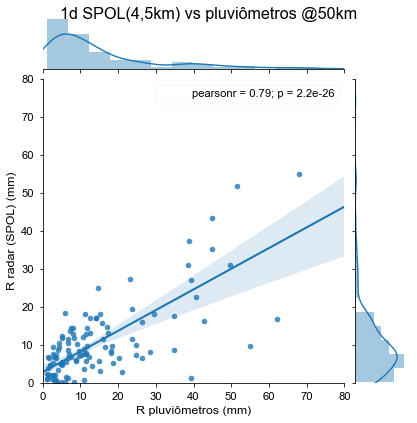

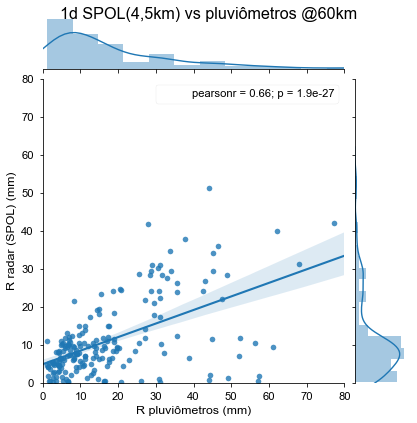

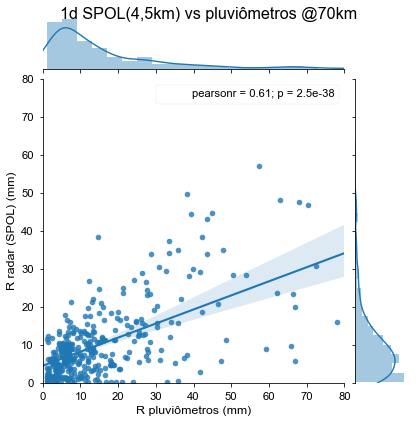

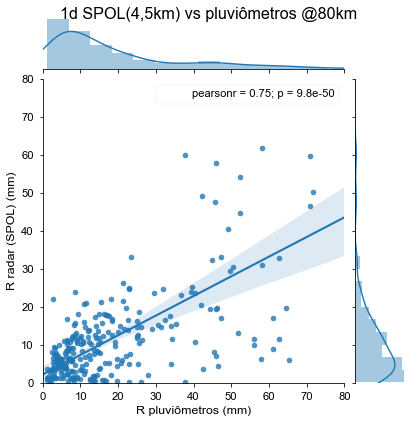

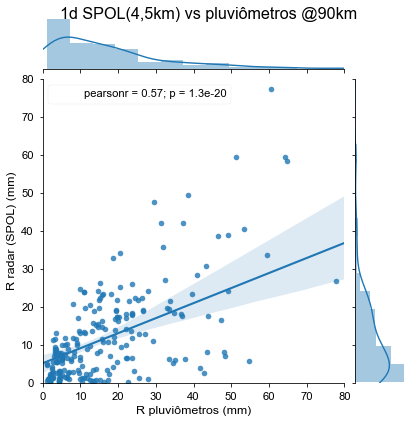

In [116]:
for dist in [50,60,70,80,90]:
    p2=(sns.jointplot(x='Rg_mm_10',y='Rspol',data=station_1d.query('Rg_mm_10>@thr & Rspol_4500>@thr & r_spol<@dist & r_spol>@dist-10').dropna(axis=0),kind='reg',
                 xlim=(0,80),ylim=(0,80)))
    p2.set_axis_labels("R pluviômetros (mm)", "R radar (SPOL) (mm)")
    fit=np.polyfit(station_1d.query('Rg_mm_10>@thr & Rspol_4500>@thr & r_spol<@dist').Rg_mm_10,
               station_1d.query('Rg_mm_10>@thr & Rspol_4500>@thr & r_spol<@dist').Rspol,deg=1)
    print('y = '+str(fit[0])+' x'+' + '+str(fit[1]))
    p2.fig.suptitle('1d SPOL(4,5km) vs pluviômetros @'+str(dist)+'km')
    p2.savefig('spol_4500_1d_'+str(dist)+'km.png')

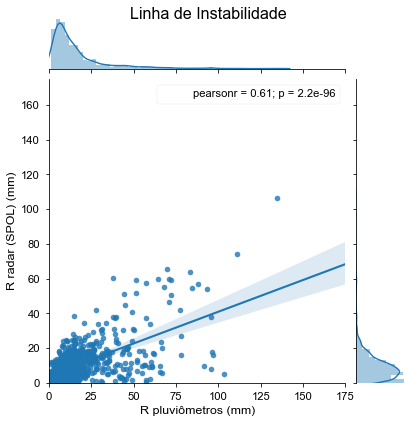

In [186]:
p2=(sns.jointplot(x='Rg_mm_10',y='Rspol',
                  data=station_1d_class.query('Rg_mm_10>@thr & Rspol_4500>@thr & Classificacao=="LI"').dropna(axis=0),
                  kind='reg',xlim=(0,175),ylim=(0,175)))
#p2.fig.subplots_adjust(top=0.9)
p2.set_axis_labels("R pluviômetros (mm)", "R radar (SPOL) (mm)")
p2.fig.suptitle('Linha de Instabilidade')
p2.savefig('spol_li.png')
p2.savefig('spol_li.svg')
p2.savefig('spol_li.pdf',bbox_inches='tight', pad_inches=0)

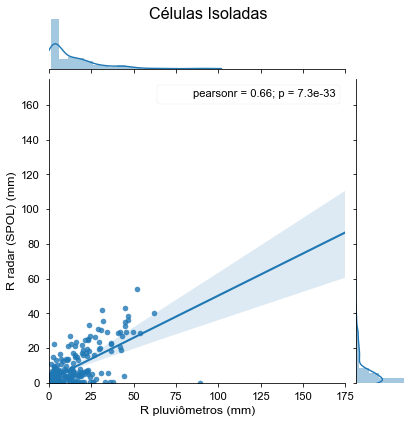

In [297]:
p2=(sns.jointplot(x='Rg_mm_10',y='Rspol',
                  data=station_1d_class.query('Rg_mm_10>@thr & Rspol_4500>@thr & Classificacao=="I"').dropna(axis=0),
                  kind='reg',xlim=(0,175),ylim=(0,175)))
#p2.fig.subplots_adjust(top=0.9)
p2.fig.suptitle('Células Isoladas')
p2.set_axis_labels("R pluviômetros (mm)", "R radar (SPOL) (mm)")
p2.savefig('spol_i.png')
p2.savefig('spol_i.svg')
p2.savefig('spol_i.pdf',bbox_inches='tight', pad_inches=0)

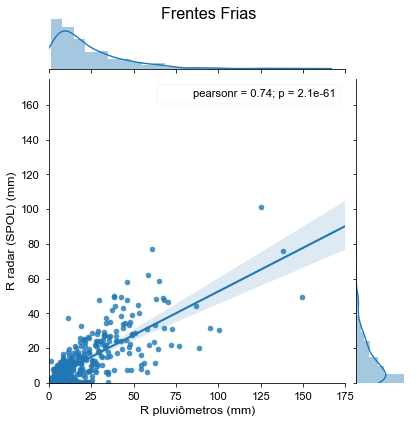

In [119]:
p2=(sns.jointplot(x='Rg_mm_10',y='Rspol',
                  data=station_1d_class.query('Rg_mm_10>@thr & Rspol_4500>@thr & Classificacao=="FF"').dropna(axis=0),
                  kind='reg',xlim=(0,175),ylim=(0,175)))
#p2.fig.subplots_adjust(top=0.9)
p2.fig.suptitle('Frentes Frias')
p2.set_axis_labels("R pluviômetros (mm)", "R radar (SPOL) (mm)")
p2.savefig('spol_ff.png')
p2.savefig('spol_ff.svg')
p2.savefig('spol_ff.pdf',bbox_inches='tight', pad_inches=0)

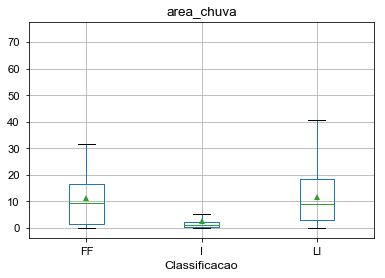

In [120]:
p=station_1d_class.dropna(axis=0).boxplot(by='Classificacao',column='area_chuva',showmeans=True)
f=p.get_figure()
f.suptitle('')
f.savefig('box_frac_class.png')
f.savefig('box_frac_class.svg')
f.savefig('box_frac_class.pdf',bbox_inches='tight', pad_inches=0)

In [290]:
station_1d_class.dropna(axis=0).groupby('Classificacao')['Rg_mm_10','Rspol'].describe()

Rg_mm_10                                                     \
                 count       mean        std  min  25%   50%   75%    max   
Classificacao                                                               
FF               497.0  16.541046  20.484681  0.0  1.0  10.4  23.8  149.4   
I               1092.0   4.013416   9.905135  0.0  0.0   0.1   2.4  114.2   
LI              1291.0  11.962277  16.101342  0.0  1.2   6.8  15.1  134.4   

                Rspol                                                \
                count      mean        std  min       25%       50%   
Classificacao                                                         
FF              497.0  9.633201  13.577194  0.0  0.282026  3.528008   
I              1092.0  2.109474   5.876118  0.0  0.000625  0.157385   
LI             1291.0  7.530790   9.746379  0.0  0.791116  5.140452   

                                      
                     75%         max  
Classificacao                         
FF             14.376904  101.502191  
I               0.924380   54.152336  
LI             10.645510  106.539237

In [289]:
station_1d_class.dropna(axis=0).groupby('Classificacao')['area_chuva'].describe()

count       mean        std  min       25%       50%  \
Classificacao                                                          
FF              497.0  11.157522   9.745746  0.0  1.603637  9.435714   
I              1092.0   2.724448   4.634657  0.0  0.321194  1.163424   
LI             1291.0  11.797898  10.905824  0.0  2.792128  8.851443   

                     75%        max  
Classificacao                        
FF             16.518053  73.943396  
I               2.286594  37.513494  
LI             18.396534  51.139371

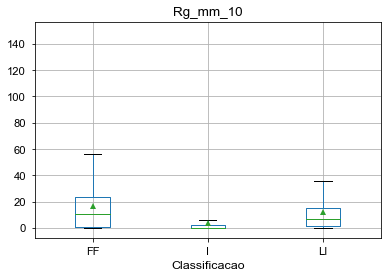

In [121]:
p=station_1d_class.dropna(axis=0).boxplot(by='Classificacao',column='Rg_mm_10',showmeans=True)
f=p.get_figure()
f.suptitle('')

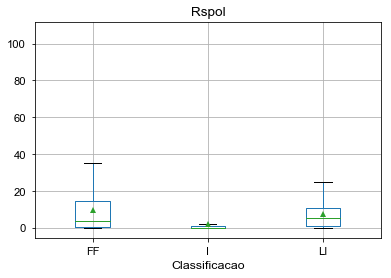

In [122]:
p=station_1d_class.dropna(axis=0).boxplot(by='Classificacao',column='Rspol',showmeans=True)
f=p.get_figure()
f.suptitle('')

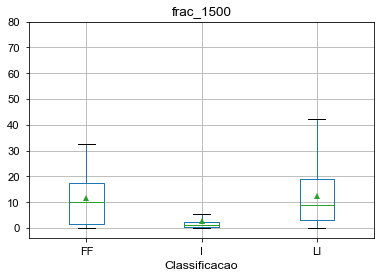

In [123]:
p=station_1d_class.dropna(axis=0).boxplot(by='Classificacao',column='frac_1500',showmeans=True)
f=p.get_figure()
f.suptitle('')

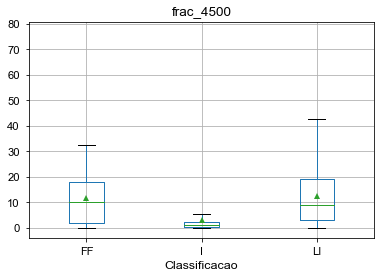

In [124]:
p=station_1d_class.dropna(axis=0).boxplot(by='Classificacao',column='frac_4500',showmeans=True)
f=p.get_figure()
f.suptitle('')

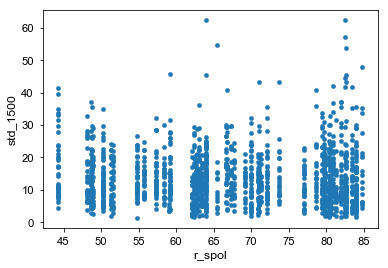

In [125]:
station_10m.query('Rg_mm_10>@thr & Rspol>@thr').dropna(axis=0).plot.scatter(y='std_1500',x='r_spol')

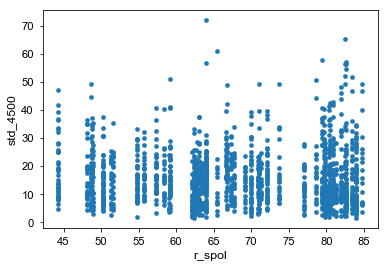

In [126]:
station_10m.query('Rg_mm_10>@thr & Rspol>@thr').dropna(axis=0).plot.scatter(y='std_4500',x='r_spol')

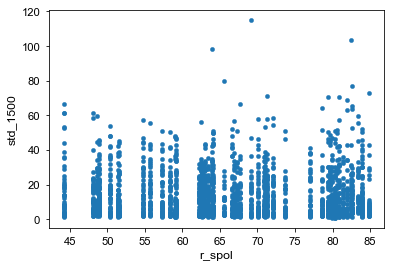

In [127]:
station_1h.query('Rg_mm_10>@thr & Rspol>@thr').dropna(axis=0).plot.scatter(y='std_1500',x='r_spol')

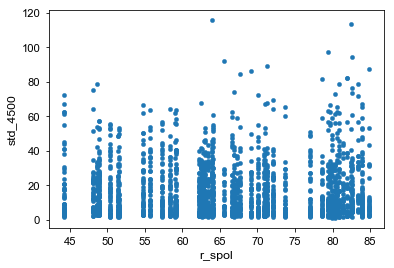

In [128]:
station_1h.query('Rg_mm_10>@thr & Rspol>@thr').dropna(axis=0).plot.scatter(y='std_4500',x='r_spol')

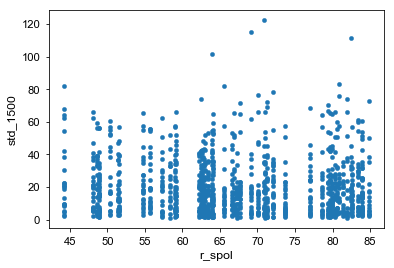

In [129]:
station_1d.query('Rg_mm_10>@thr & Rspol>@thr').dropna(axis=0).plot.scatter(y='std_1500',x='r_spol')

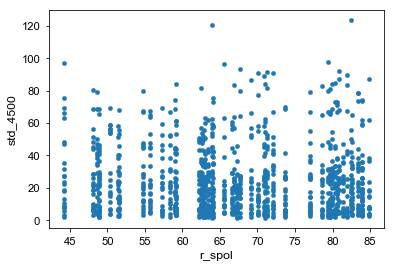

In [130]:
station_1d.query('Rg_mm_10>@thr & Rspol>@thr').dropna(axis=0).plot.scatter(y='std_4500',x='r_spol')

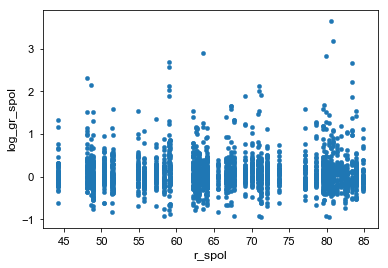

In [131]:
station_1h.query('Rg_mm_10>@thr').dropna(axis=0).plot.scatter(y='log_gr_spol',x='r_spol')

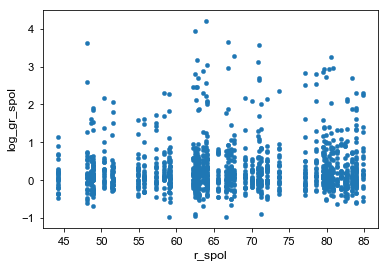

In [132]:
station_1d.query('Rg_mm_10>@thr').dropna(axis=0).plot.scatter(y='log_gr_spol',x='r_spol')

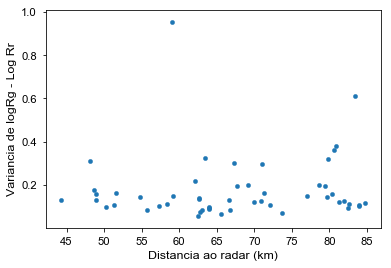

In [133]:
var_log_gr_1h.dropna(axis=0).plot.scatter(y='log_2_gr_spol',x='r_spol').set(xlabel='Distancia ao radar (km)',
                                                             ylabel='Variancia de logRg - Log Rr')

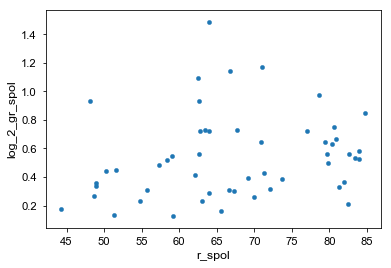

In [134]:
var_log_gr_1d.dropna(axis=0).plot.scatter(y='log_2_gr_spol',x='r_spol')

## Contingency Tables for rainfall gauges vs rainfall radar

#pd.crosstab(station_2min.Rg_mm_10min>=0,station_2min.rz>=0)

pd.crosstab(station_10min.Rg_mm_10=0,station_10min.rz>=0)

In [135]:
station_1h[['Rg_mm_10','Rspol']].dropna(axis=0).corr()

Rg_mm_10     Rspol
Rg_mm_10  1.000000  0.544135
Rspol     0.544135  1.000000

In [136]:
station_1d[['Rg_mm_10','Rspol']].dropna(axis=0).corr()

Rg_mm_10     Rspol
Rg_mm_10  1.000000  0.729785
Rspol     0.729785  1.000000

In [141]:
ct10m=pd.crosstab(station_10m.dropna(axis=0).Rg_mm_10>thr,station_10m.dropna(axis=0).Rspol>thr)
ct10m

Rspol     False  True 
Rg_mm_10              
False     52568   1852
True       1422   1536

In [142]:
ct1h=pd.crosstab(station_1h.dropna(axis=0).Rg_mm_10>thr,station_1h.dropna(axis=0).Rspol>thr)
ct1h

Rspol     False  True 
Rg_mm_10              
False     10460   1231
True        363   2043

In [143]:
ct1d=pd.crosstab(station_1d.dropna(axis=0).Rg_mm_10>thr,station_1d.dropna(axis=0).Rspol>thr)
ct1d

Rspol     False  True 
Rg_mm_10              
False       548    112
True        171   1079

In [182]:
CSI=ct10m[1][1]*100./(ct10m[1][1]+ct10m[1][0]+ct10m[0][1])
BIAS=(ct10m[1][1]+ct10m[1][0])*100./(ct10m[1][1]+ct10m[0][1])
FAR=ct10m[0][1]*100./(ct10m[1][1]+ct10m[1][0])
Hit=ct10m[1][1]*100./(ct10m[1][1]+ct10m[0][1])
print('CSI: ',CSI,'BIAS: ',BIAS,'FAR: ',FAR,'HIT: ',Hit,'Sucess: ',100-FAR)

(u'CSI: ', 31.933471933471935, u'BIAS: ', 114.5368492224476, u'FAR: ', 41.971664698937424, u'HIT: ', 51.926977687626774, u'Sucess: ', 58.028335301062576)


In [183]:
CSI=ct1h[1][1]*100./(ct1h[1][1]+ct1h[1][0]+ct1h[0][1])
BIAS=(ct1h[1][1]+ct1h[1][0])*100./(ct1h[1][1]+ct1h[0][1])
FAR=ct1h[0][1]*100./(ct1h[1][1]+ct1h[1][0])
Hit=ct1h[1][1]*100./(ct1h[1][1]+ct1h[0][1])
print('CSI: ',CSI,'BIAS: ',BIAS,'FAR: ',FAR,'HIT: ',Hit,'Sucess: ',100-FAR)

(u'CSI: ', 56.172669782788013, u'BIAS: ', 136.07647547797174, u'FAR: ', 11.087354917532071, u'HIT: ', 84.912718204488783, u'Sucess: ', 88.912645082467932)


In [184]:
CSI=ct1d[1][1]*100./(ct1d[1][1]+ct1d[1][0]+ct1d[0][1])
BIAS=(ct1d[1][1]+ct1d[1][0])*100./(ct1d[1][1]+ct1d[0][1])
FAR=ct1d[0][1]*100./(ct1d[1][1]+ct1d[1][0])
Hit=ct1d[1][1]*100./(ct1d[1][1]+ct1d[0][1])
print('CSI: ',CSI,'BIAS: ',BIAS,'FAR: ',FAR,'HIT: ',Hit,'Sucess: ',100-FAR)

(u'CSI: ', 79.221732745961816, u'BIAS: ', 95.280000000000001, u'FAR: ', 14.357682619647354, u'HIT: ', 86.319999999999993, u'Sucess: ', 85.642317380352651)
